In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from textwrap import wrap
from textblob import TextBlob

from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from scipy.cluster.hierarchy import dendrogram

import re
import string
import time
from PIL import Image
from collections import Counter

import plotly.express as px

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words as nltk_words
from nltk.corpus import stopwords

nltk.download('stopwords', download_dir='../resources')
nltk.download('punkt', download_dir='../resources')
nltk.download('wordnet', download_dir='../resources')
nltk.download('omw-1.4', download_dir='../resources')
nltk.download('words', download_dir='../resources')

[nltk_data] Downloading package stopwords to ./resources...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to ./resources...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to ./resources...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to ./resources...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to ./resources...
[nltk_data]   Package words is already up-to-date!


In [ ]:
nltk.data.path.append('../resources')

# TODO:
* apply models **[DONE]**
* compare with google trends **[DONE]**
* change wordcloud colors **[DONE]**
* apply all to descriptions **[DONE]**
* run wss for KMeans
* run online algorithms

## Trends limits:
By default, it is set to 100 requests per 100 seconds per user and can be adjusted to a maximum value of 1,000. But the number of requests to the API is restricted to a maximum of 10 requests per second per user.

### Configs...

In [3]:
TRENDS = False

# Exploratory Data Analysis

In [4]:
data = pd.read_csv('../data/bbc_news.csv')
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
8116  What time is the Queen's funeral? Who will wea...   
8117  Queen's funeral guests: Who will - and who won...   
8118    The cowboy and the Queen who bonded over horses   
8119   Queen amused by an American's breach of protocol   
8120  Queen Elizabeth II's special connection with W...   

                            pubDate  \
0     Mon, 07 Mar 2022 08:01:56 GMT   
1     Sun, 06 Mar 2022 22:49:58 GMT   
2     Mon, 07 Mar 2022 00:14:42 GMT   
3     Mon, 07 Mar 2022 00:05:40 GMT   
4     Mon, 07 Mar 2022 08:15:53 GMT   
...                             ...   
8116  Sat, 17 Sep 2022 22:54:46 GMT   
8117  Sat, 17 Sep 2022 06:25:17 GMT   
8118  Fri, 16 Sep 2022 23:01:06 GMT   
8119  Fri, 16 Sep 2022 14:52:59 GMT   
8120  Sat, 17 Sep 2022 06:38:22 GMT   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
8116             https://www.bbc.co.uk/news/uk-62844663   
8117             https://www.bbc.co.uk/news/uk-62890879   
8118  https://www.bbc.co.uk/news/world-us-canada-629...   
8119  https://www.bbc.co.uk/news/world-us-canada-629...   
8120  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
8116  https://www.bbc.co.uk/news/uk-62844663?at_medi...   
8117  https://www.bbc.co.uk/news/uk-62890879?at_medi...   
8118  https://www.bbc.co.uk/news/world-us-canada-629...   
8119  https://www.bbc.co.uk/news/world-us-canada-629...   
8120  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  
0     The Ukrainian president says the country will ...  
1     Jeremy Bowen was on the frontline in Irpin, as...  
2     One of the world's biggest fertiliser firms sa...  
3     The parents of the Manchester Arena bombing's ...  
4     Consumers are feeling the impact of higher ene...  
...                                                 ...  
8116  The death of Queen Elizabeth II has had a majo...  
8117  Here's what we know so far about who will and ...  
8118  Sitting with the heads of state at Monday's fu...  
8119  When the monarch visited a US housing project ...  
8120  The Queen's association with Windsor Great Par...  

[8121 rows x 5 columns]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8121 entries, 0 to 8120
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        8121 non-null   object
 1   pubDate      8121 non-null   object
 2   guid         8121 non-null   object
 3   link         8121 non-null   object
 4   description  8121 non-null   object
dtypes: object(5)
memory usage: 317.4+ KB


In [6]:
data.describe()

title  \
count                                                8121   
unique                                               7746   
top     Ukraine war in maps: Tracking the Russian inva...   
freq                                                   32   

                              pubDate  \
count                            8121   
unique                           7981   
top     Fri, 15 Jul 2022 15:23:03 GMT   
freq                                3   

                                                    guid  \
count                                               8121   
unique                                              7432   
top     https://www.bbc.co.uk/news/world-europe-60506682   
freq                                                  40   

                                                     link  \
count                                                8121   
unique                                               7432   
top     https://www.bbc.co.uk/news/world-europe-605066...   
freq                                                   40   

                                              description  
count                                                8121  
unique                                               7645  
top     How closely have you been paying attention to ...  
freq                                                   23

In [7]:
data['pubDate'] = pd.to_datetime(data['pubDate'], infer_datetime_format=True)
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
8116  What time is the Queen's funeral? Who will wea...   
8117  Queen's funeral guests: Who will - and who won...   
8118    The cowboy and the Queen who bonded over horses   
8119   Queen amused by an American's breach of protocol   
8120  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
8116 2022-09-17 22:54:46+00:00   
8117 2022-09-17 06:25:17+00:00   
8118 2022-09-16 23:01:06+00:00   
8119 2022-09-16 14:52:59+00:00   
8120 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
8116             https://www.bbc.co.uk/news/uk-62844663   
8117             https://www.bbc.co.uk/news/uk-62890879   
8118  https://www.bbc.co.uk/news/world-us-canada-629...   
8119  https://www.bbc.co.uk/news/world-us-canada-629...   
8120  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
8116  https://www.bbc.co.uk/news/uk-62844663?at_medi...   
8117  https://www.bbc.co.uk/news/uk-62890879?at_medi...   
8118  https://www.bbc.co.uk/news/world-us-canada-629...   
8119  https://www.bbc.co.uk/news/world-us-canada-629...   
8120  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  
0     The Ukrainian president says the country will ...  
1     Jeremy Bowen was on the frontline in Irpin, as...  
2     One of the world's biggest fertiliser firms sa...  
3     The parents of the Manchester Arena bombing's ...  
4     Consumers are feeling the impact of higher ene...  
...                                                 ...  
8116  The death of Queen Elizabeth II has had a majo...  
8117  Here's what we know so far about who will and ...  
8118  Sitting with the heads of state at Monday's fu...  
8119  When the monarch visited a US housing project ...  
8120  The Queen's association with Windsor Great Par...  

[8121 rows x 5 columns]

## Remove duplicates

In [9]:
data = data.drop_duplicates(subset=['title']).drop_duplicates(subset=['guid']).drop_duplicates(subset=['description']).reset_index(drop=True)
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  
0     The Ukrainian president says the country will ...  
1     Jeremy Bowen was on the frontline in Irpin, as...  
2     One of the world's biggest fertiliser firms sa...  
3     The parents of the Manchester Arena bombing's ...  
4     Consumers are feeling the impact of higher ene...  
...                                                 ...  
7359  Saracens battle back from 17-0 down to beat Ha...  
7360  Thousands of people have lined up for miles to...  
7361  Sitting with the heads of state at Monday's fu...  
7362  When the monarch visited a US housing project ...  
7363  The Queen's association with Windsor Great Par...  

[7364 rows x 5 columns]

In [10]:
STOPWORDS = stopwords.words('english')
pd.Series(STOPWORDS)

0             i
1            me
2            my
3        myself
4            we
         ...   
174     weren't
175         won
176       won't
177      wouldn
178    wouldn't
Length: 179, dtype: object

## Remove stopwords and count frequencies for single words

In [11]:
sns.set_style('darkgrid')

In [12]:
top_N = 50
a = data['description'].str.lower().str.replace(r'[^\w\s]', '', regex=True).str.cat(sep=' ')
words = list(filter(lambda w: w not in STOPWORDS, nltk.tokenize.word_tokenize(a)))
word_dist = nltk.FreqDist(words)
freq_title = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])
freq_title

Word  Frequency
0         says        784
1        first        381
2      england        362
3       people        351
4          new        342
5      ukraine        318
6          bbc        298
7          say        298
8           uk        273
9          one        270
10       world        254
11         win        253
12      league        251
13       years        244
14         two        234
15     russian        232
16          us        232
17       final        198
18       could        192
19         day        192
20        city        188
21  manchester        175
22         war        175
23      russia        166
24       watch        157
25        time        156
26        2022        154
27        home        151
28      police        147
29        open        141
30      womens        137
31   president        136
32  government        135
33   ukrainian        134
34        back        134
35        help        133
36     victory        131
37         cup        131
38      former        130
39        year        130
40        lead        126
41       since        123
42      papers        120
43      second        116
44       three        114
45        beat        110
46   champions        108
47       games        107
48      family        105
49        many        102

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, 'says'),
  Text(1, 0, 'first'),
  Text(2, 0, 'england'),
  Text(3, 0, 'people'),
  Text(4, 0, 'new'),
  Text(5, 0, 'ukraine'),
  Text(6, 0, 'bbc'),
  Text(7, 0, 'say'),
  Text(8, 0, 'uk'),
  Text(9, 0, 'one'),
  Text(10, 0, 'world'),
  Text(11, 0, 'win'),
  Text(12, 0, 'league'),
  Text(13, 0, 'years'),
  Text(14, 0, 'two'),
  Text(15, 0, 'russian'),
  Text(16, 0, 'us'),
  Text(17, 0, 'final'),
  Text(18, 0, 'could'),
  Text(19, 0, 'day'),
  Text(20, 0, 'city'),
  Text(21, 0, 'manchester'),
  Text(22, 0, 'war'),
  Text(23, 0, 'russia'),
  Text(24, 0, 'watch'),
  Text(25, 0, 'time'),
  Text(26, 0, '2022'),
  Text(27, 0, 'home'),
  Text(28, 0, 'police'),
  Text(29, 0, 'open'),
  Text(30, 0, 'womens'),
  Text(31, 0, 'president'),
  Text(32, 0, 'governmen

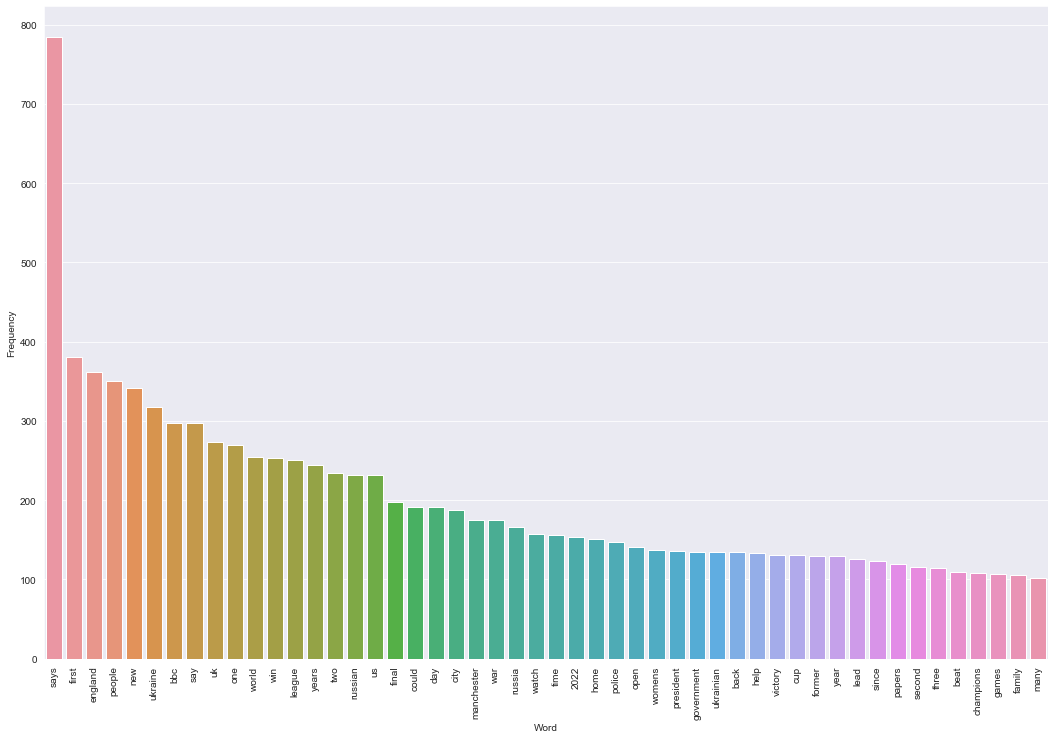

In [13]:
plt.figure(figsize=(18, 12))
sns.barplot(data=freq_title, x='Word', y='Frequency')
plt.xticks(rotation=90)

## Looking for the most popular 2-grams and 3-grams

In [14]:
def find_ngrams(input_list, n):
    return list(zip(*(input_list[i:] for i in range(n))))

In [15]:
bigrams = find_ngrams(words, 2)
bigrams

[('ukrainian', 'president'),
 ('president', 'says'),
 ('says', 'country'),
 ('country', 'forgive'),
 ('forgive', 'forget'),
 ('forget', 'murder'),
 ('murder', 'civilians'),
 ('civilians', 'jeremy'),
 ('jeremy', 'bowen'),
 ('bowen', 'frontline'),
 ('frontline', 'irpin'),
 ('irpin', 'residents'),
 ('residents', 'came'),
 ('came', 'russian'),
 ('russian', 'fire'),
 ('fire', 'trying'),
 ('trying', 'flee'),
 ('flee', 'one'),
 ('one', 'worlds'),
 ('worlds', 'biggest'),
 ('biggest', 'fertiliser'),
 ('fertiliser', 'firms'),
 ('firms', 'says'),
 ('says', 'conflict'),
 ('conflict', 'could'),
 ('could', 'deliver'),
 ('deliver', 'shock'),
 ('shock', 'food'),
 ('food', 'supplies'),
 ('supplies', 'parents'),
 ('parents', 'manchester'),
 ('manchester', 'arena'),
 ('arena', 'bombings'),
 ('bombings', 'youngest'),
 ('youngest', 'victim'),
 ('victim', 'speak'),
 ('speak', 'life'),
 ('life', 'since'),
 ('since', 'died'),
 ('died', 'consumers'),
 ('consumers', 'feeling'),
 ('feeling', 'impact'),
 ('impact

In [16]:
bigrams_dist = nltk.FreqDist(bigrams)
bigram_freq_title = pd.DataFrame(bigrams_dist.most_common(top_N),
                    columns=['N-gram', 'Frequency'])
bigram_freq_title

N-gram  Frequency
0            (euro, 2022)         94
1       (premier, league)         88
2            (world, cup)         78
3   (commonwealth, games)         78
4        (boris, johnson)         76
5      (manchester, city)         75
6     (champions, league)         75
7    (manchester, united)         58
8           (first, time)         58
9       (prime, minister)         56
10        (south, africa)         53
11         (front, pages)         52
12         (cost, living)         49
13           (bbc, sport)         47
14           (liz, truss)         45
15         (lead, papers)         42
16          (police, say)         41
17        (social, media)         41
18             (us, open)         39
19    (northern, ireland)         38
20           (tells, bbc)         35
21         (war, ukraine)         33
22    (watch, highlights)         32
23     (queen, elizabeth)         32
24         (rishi, sunak)         31
25         (new, zealand)         30
26         (real, madrid)         30
27       (emma, raducanu)         29
28      (russian, forces)         27
29           (years, ago)         27
30          (grand, prix)         27
31        (elizabeth, ii)         27
32          (grand, slam)         26
33         (french, open)         26
34      (great, britains)         26
35     (tory, leadership)         26
36           (final, day)         25
37              (fa, cup)         25
38           (match, day)         24
39          (number, one)         24
40          (watch, best)         23
41       (europa, league)         22
42           (two, years)         22
43            (new, york)         22
44        (league, final)         22
45    (games, birmingham)         22
46    (russias, invasion)         21
47    (invasion, ukraine)         21
48        (womens, world)         21
49        (old, trafford)         21

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, "('euro', '2022')"),
  Text(1, 0, "('premier', 'league')"),
  Text(2, 0, "('world', 'cup')"),
  Text(3, 0, "('commonwealth', 'games')"),
  Text(4, 0, "('boris', 'johnson')"),
  Text(5, 0, "('manchester', 'city')"),
  Text(6, 0, "('champions', 'league')"),
  Text(7, 0, "('manchester', 'united')"),
  Text(8, 0, "('first', 'time')"),
  Text(9, 0, "('prime', 'minister')"),
  Text(10, 0, "('south', 'africa')"),
  Text(11, 0, "('front', 'pages')"),
  Text(12, 0, "('cost', 'living')"),
  Text(13, 0, "('bbc', 'sport')"),
  Text(14, 0, "('liz', 'truss')"),
  Text(15, 0, "('lead', 'papers')"),
  Text(16, 0, "('police', 'say')"),
  Text(17, 0, "('social', 'media')"),
  Text(18, 0, "('us', 'open')"),
  Text(19, 0, "('northern', 'ireland')"),
  Text(20, 0, "('tell

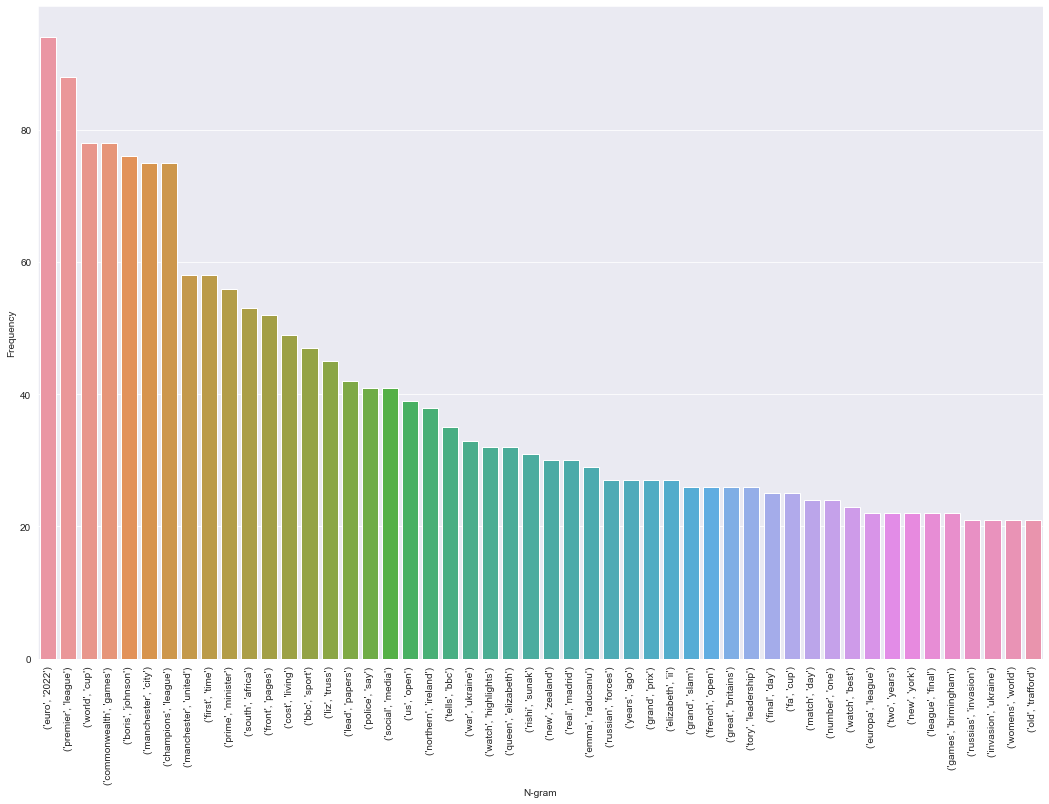

In [17]:
plt.figure(figsize=(18, 12))
sns.barplot(data=bigram_freq_title, x='N-gram', y='Frequency')
plt.xticks(rotation=90)

In [18]:
trigrams = find_ngrams(words, 3)
trigrams

[('ukrainian', 'president', 'says'),
 ('president', 'says', 'country'),
 ('says', 'country', 'forgive'),
 ('country', 'forgive', 'forget'),
 ('forgive', 'forget', 'murder'),
 ('forget', 'murder', 'civilians'),
 ('murder', 'civilians', 'jeremy'),
 ('civilians', 'jeremy', 'bowen'),
 ('jeremy', 'bowen', 'frontline'),
 ('bowen', 'frontline', 'irpin'),
 ('frontline', 'irpin', 'residents'),
 ('irpin', 'residents', 'came'),
 ('residents', 'came', 'russian'),
 ('came', 'russian', 'fire'),
 ('russian', 'fire', 'trying'),
 ('fire', 'trying', 'flee'),
 ('trying', 'flee', 'one'),
 ('flee', 'one', 'worlds'),
 ('one', 'worlds', 'biggest'),
 ('worlds', 'biggest', 'fertiliser'),
 ('biggest', 'fertiliser', 'firms'),
 ('fertiliser', 'firms', 'says'),
 ('firms', 'says', 'conflict'),
 ('says', 'conflict', 'could'),
 ('conflict', 'could', 'deliver'),
 ('could', 'deliver', 'shock'),
 ('deliver', 'shock', 'food'),
 ('shock', 'food', 'supplies'),
 ('food', 'supplies', 'parents'),
 ('supplies', 'parents', 'man

In [19]:
trigrams_dist = nltk.FreqDist(trigrams)
trigram_freq_title = pd.DataFrame(trigrams_dist.most_common(top_N),
                    columns=['N-gram', 'Frequency'])
trigram_freq_title

N-gram  Frequency
0              (queen, elizabeth, ii)         25
1   (commonwealth, games, birmingham)         22
2         (2022, commonwealth, games)         21
3                (womens, world, cup)         20
4              (cost, living, crisis)         16
5                (world, number, one)         14
6          (champions, league, final)         14
7    (european, womens, championship)         13
8                (king, charles, iii)         13
9                 (euro, 2022, final)         12
10             (top, premier, league)         11
11               (come, behind, beat)         11
12           (premier, league, title)         11
13               (test, new, zealand)         11
14               (first, time, since)         10
15               (watch, best, shots)         10
16              (find, garth, crooks)          9
17            (garth, crooks, latest)          9
18             (crooks, latest, team)          9
19               (latest, team, week)          9
20              (world, cup, playoff)          9
21         (shares, business, advice)          9
22               (first, grand, slam)          9
23                   (erik, ten, hag)          9
24                   (fa, cup, final)          9
25  (european, championships, munich)          9
26       (russias, invasion, ukraine)          8
27                (bbc, sport, looks)          8
28                  (red, bulls, max)          8
29           (bulls, max, verstappen)          8
30             (british, number, one)          8
31       (britains, dina, ashersmith)          8
32       (watch, highlights, england)          8
33           (chief, cricket, writer)          8
34         (cricket, writer, stephan)          8
35         (writer, stephan, shemilt)          8
36                 (tour, de, france)          8
37            (womens, super, league)          7
38             (boris, johnson, says)          7
39                    (match, day, 2)          7
40             (womens, six, nations)          7
41                 (day, third, test)          7
42                (number, one, emma)          7
43              (one, emma, raducanu)          7
44              (boss, jurgen, klopp)          7
45              (jurgen, klopp, says)          7
46             (emma, raducanu, says)          7
47            (us, pga, championship)          7
48           (watch, great, britains)          7
49          (premier, league, season)          7

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, "('queen', 'elizabeth', 'ii')"),
  Text(1, 0, "('commonwealth', 'games', 'birmingham')"),
  Text(2, 0, "('2022', 'commonwealth', 'games')"),
  Text(3, 0, "('womens', 'world', 'cup')"),
  Text(4, 0, "('cost', 'living', 'crisis')"),
  Text(5, 0, "('world', 'number', 'one')"),
  Text(6, 0, "('champions', 'league', 'final')"),
  Text(7, 0, "('european', 'womens', 'championship')"),
  Text(8, 0, "('king', 'charles', 'iii')"),
  Text(9, 0, "('euro', '2022', 'final')"),
  Text(10, 0, "('top', 'premier', 'league')"),
  Text(11, 0, "('come', 'behind', 'beat')"),
  Text(12, 0, "('premier', 'league', 'title')"),
  Text(13, 0, "('test', 'new', 'zealand')"),
  Text(14, 0, "('first', 'time', 'since')"),
  Text(15, 0, "('watch', 'best', 'shots')"),
  Text(16, 0, "('

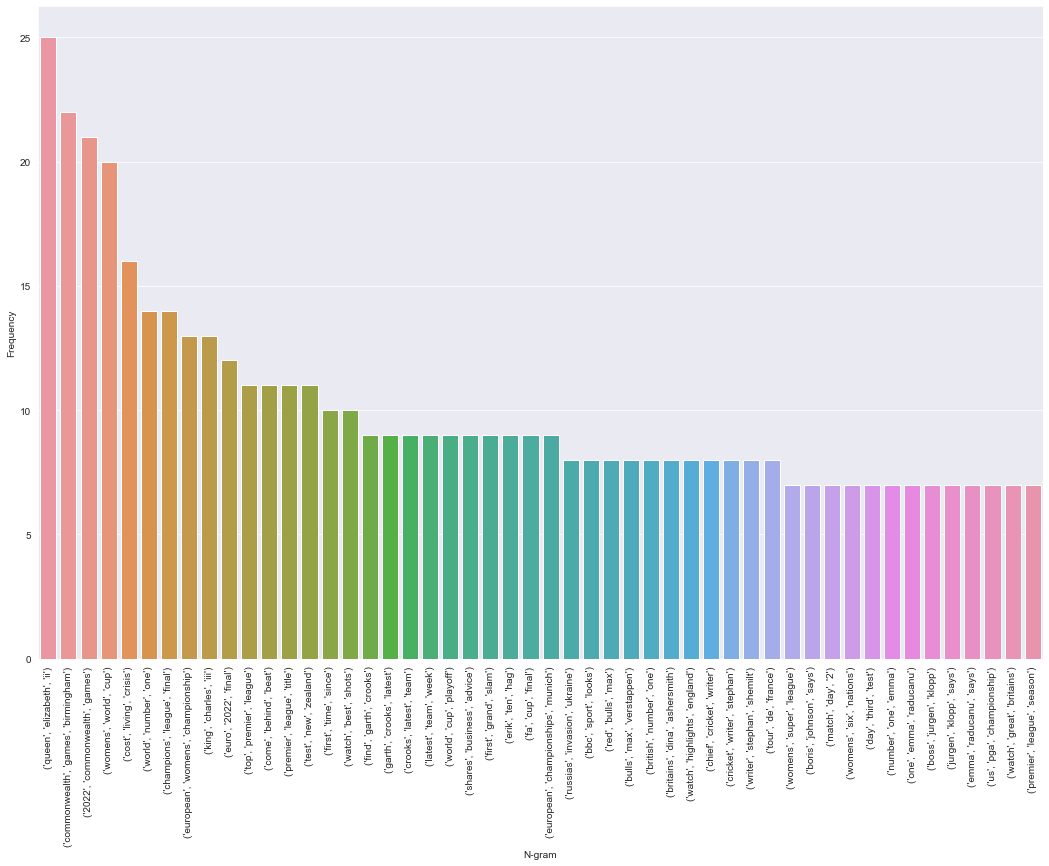

In [20]:
plt.figure(figsize=(18, 12))
sns.barplot(data=trigram_freq_title, x='N-gram', y='Frequency')
plt.xticks(rotation=90)

# Trends analyzing with pytrends

In [21]:
trends = TrendReq(hl='en-US', tz=360, retries=2, backoff_factor=0.1)
trends

In [22]:
timeframe = f'{data["pubDate"].min().strftime("%Y-%m-%d")} {data["pubDate"].max().strftime("%Y-%m-%d")}' # timeframe
timeframe

'2019-10-29 2022-09-18'

In [27]:
top_kws = list(map(lambda x: ' '.join(x[0]), bigrams_dist.most_common(10)))
top_kws

['euro 2022',
 'premier league',
 'world cup',
 'commonwealth games',
 'boris johnson',
 'manchester city',
 'champions league',
 'manchester united',
 'first time',
 'prime minister']

In [28]:
if TRENDS: # rerun only on demand, since very long running code
    trend_data = pd.DataFrame()
    for kw in top_kws:
        trends.build_payload(kw_list=[kw], timeframe=timeframe)
        trend_data = pd.concat([trend_data, trends.interest_by_region()], axis=1)
        time.sleep(2)
        print(trends.interest_by_region().sort_values(by=[kw], ascending=False))
#     print(trend_data.sort_values(by=top_kws, ascending=False))

                 euro 2022
geoName                   
Iceland                100
Cameroon                82
North Macedonia         61
Côte d’Ivoire           53
Italy                   49
...                    ...
Honduras                 0
Hong Kong                0
Iran                     0
Iraq                     0
Åland Islands            0

[250 rows x 1 columns]
               premier league
geoName                      
South Sudan               100
Uganda                     94
Sierra Leone               51
Ethiopia                   46
Namibia                    45
...                       ...
Iraq                        0
Isle of Man                 0
Japan                       0
Jersey                      0
Åland Islands               0

[250 rows x 1 columns]
                      world cup
geoName                        
Qatar                       100
Pakistan                     83
Bangladesh                   78
Nepal                        73
United Arab Emirate

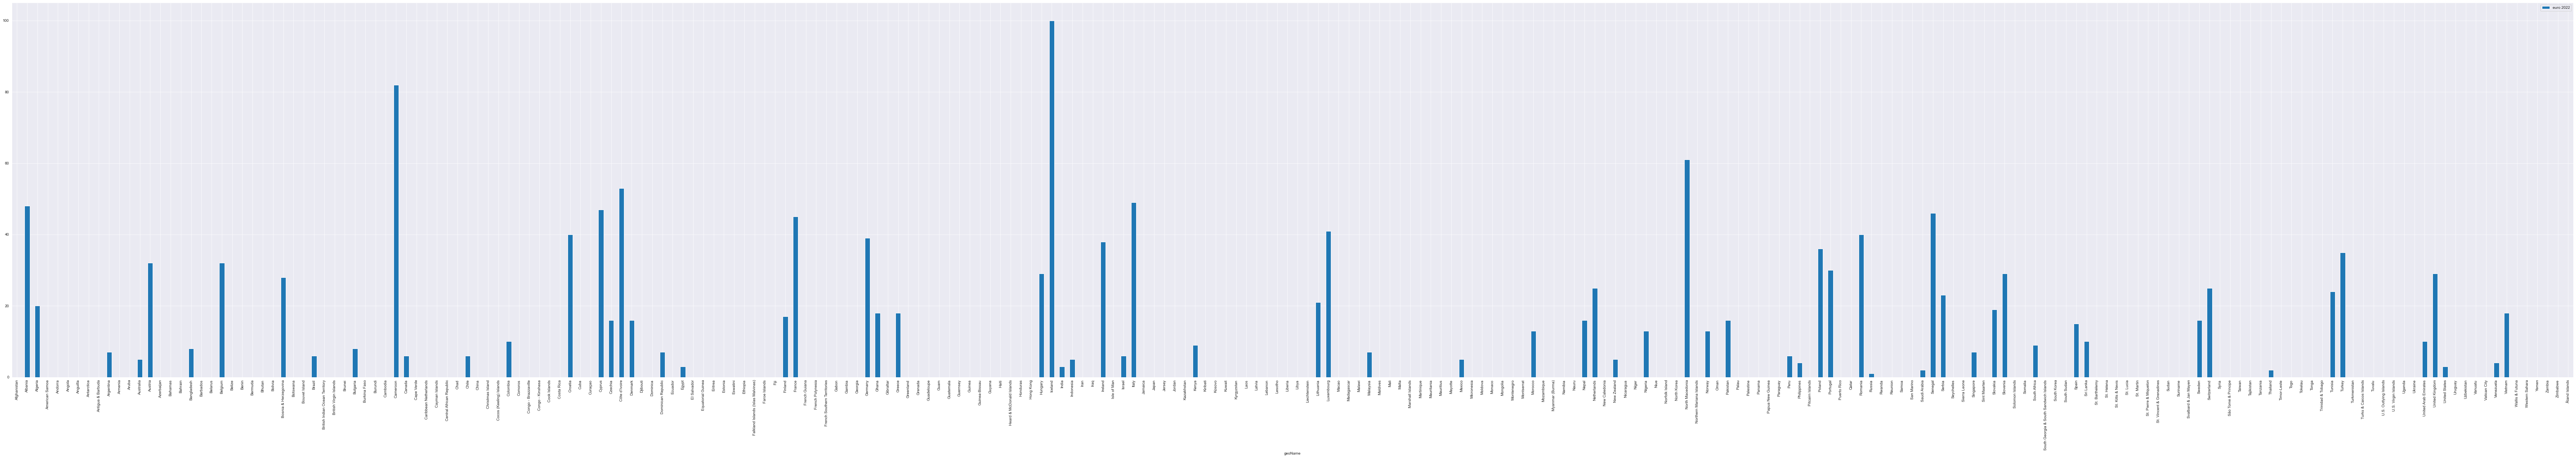

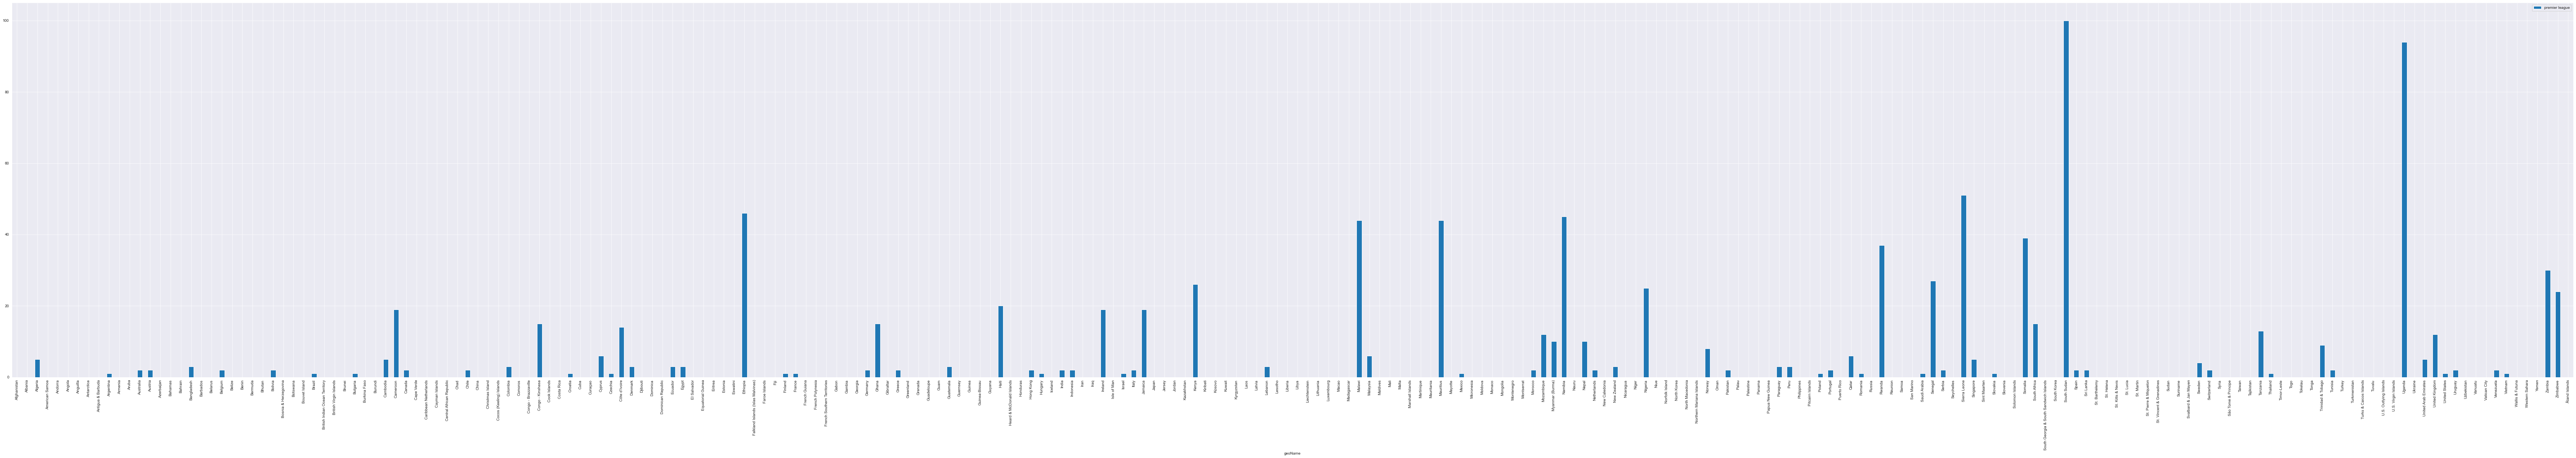

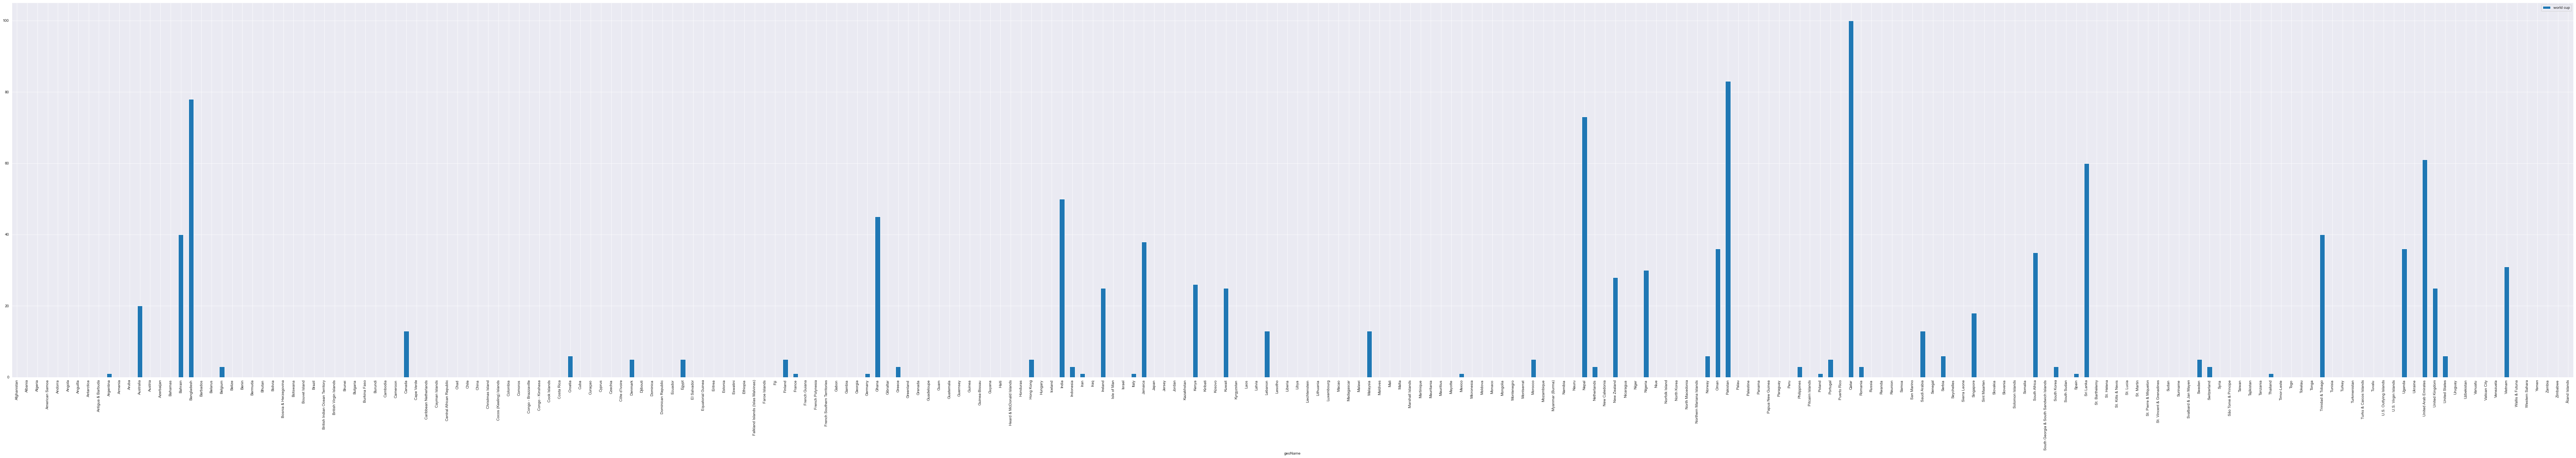

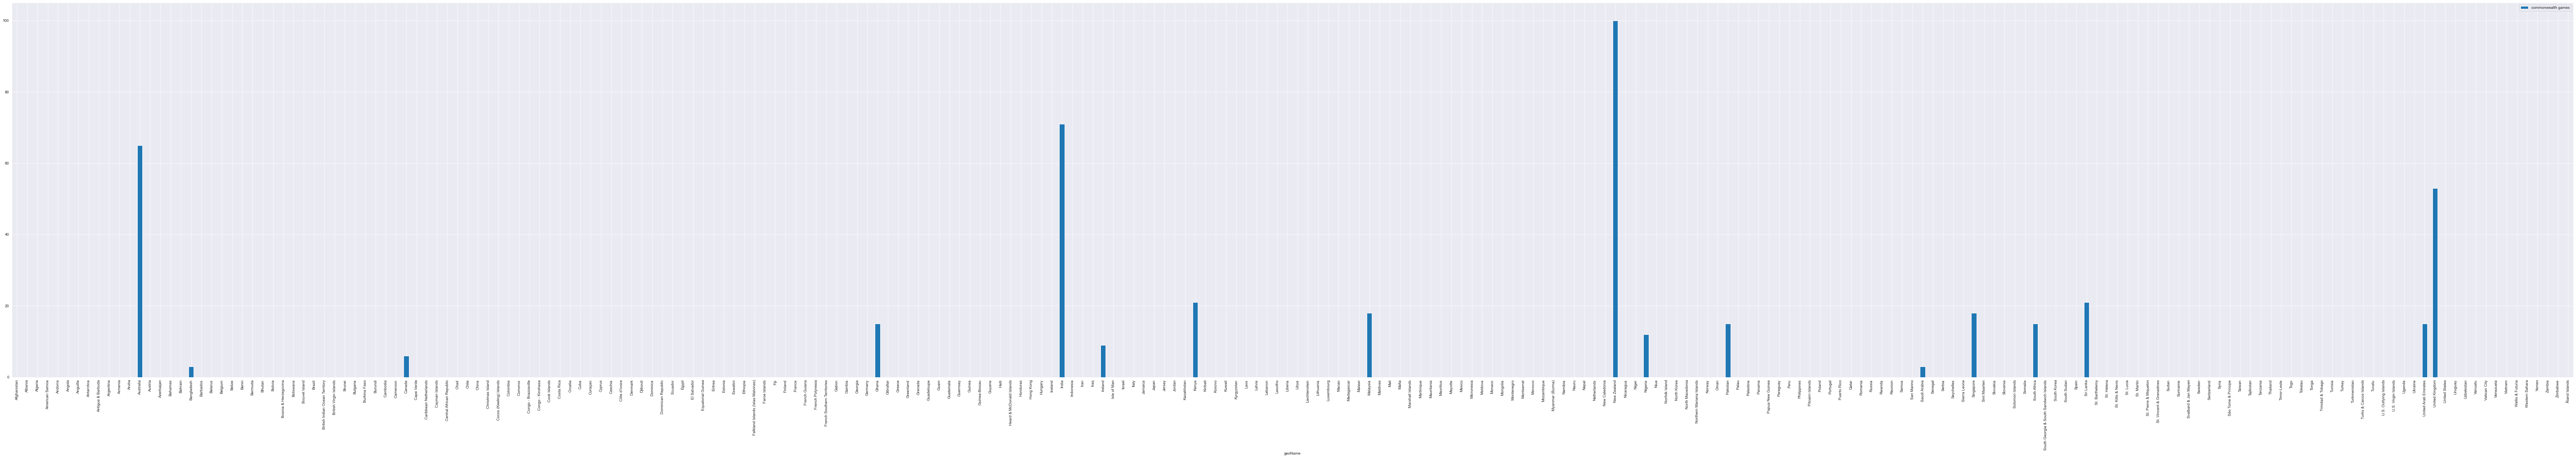

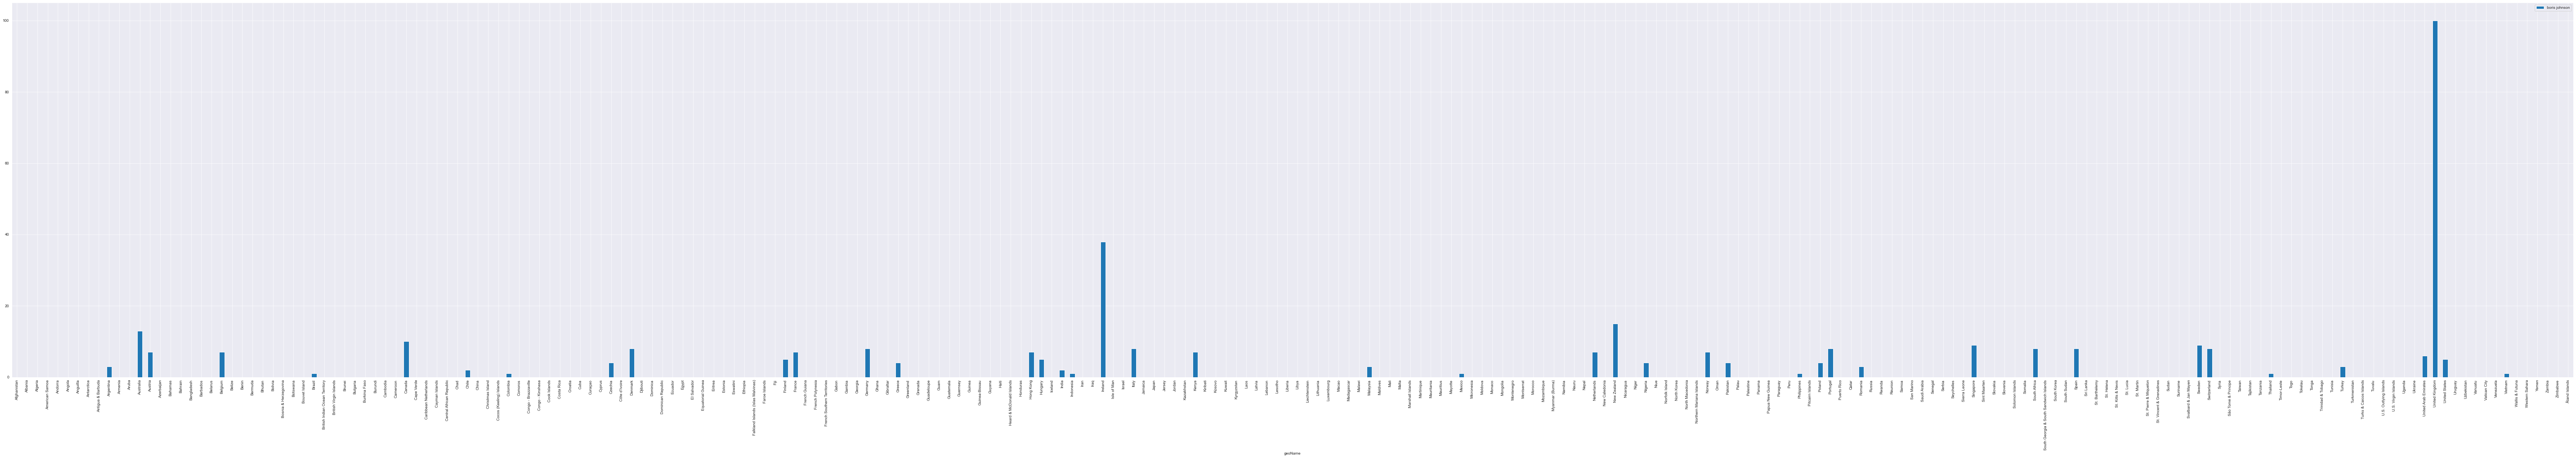

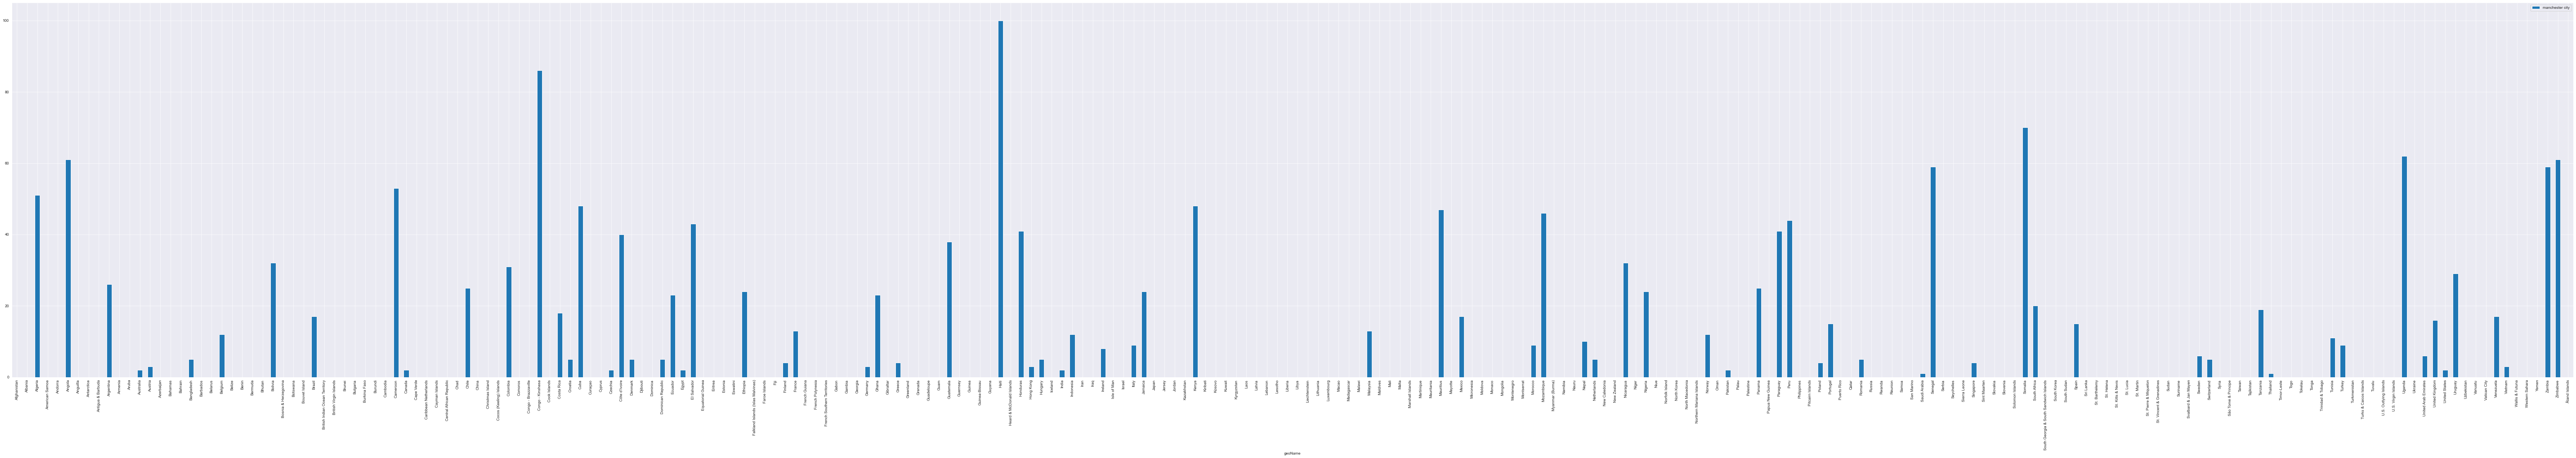

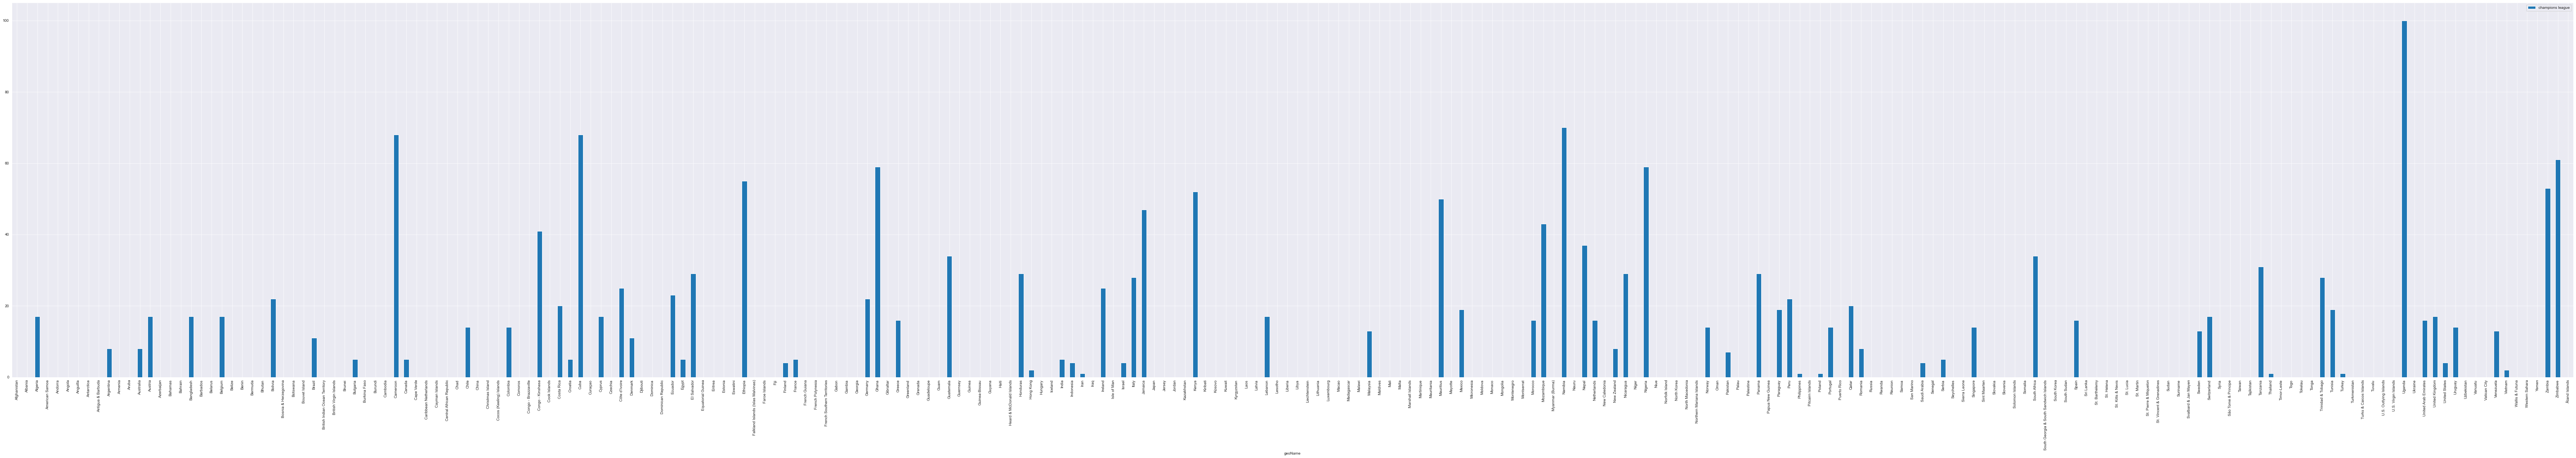

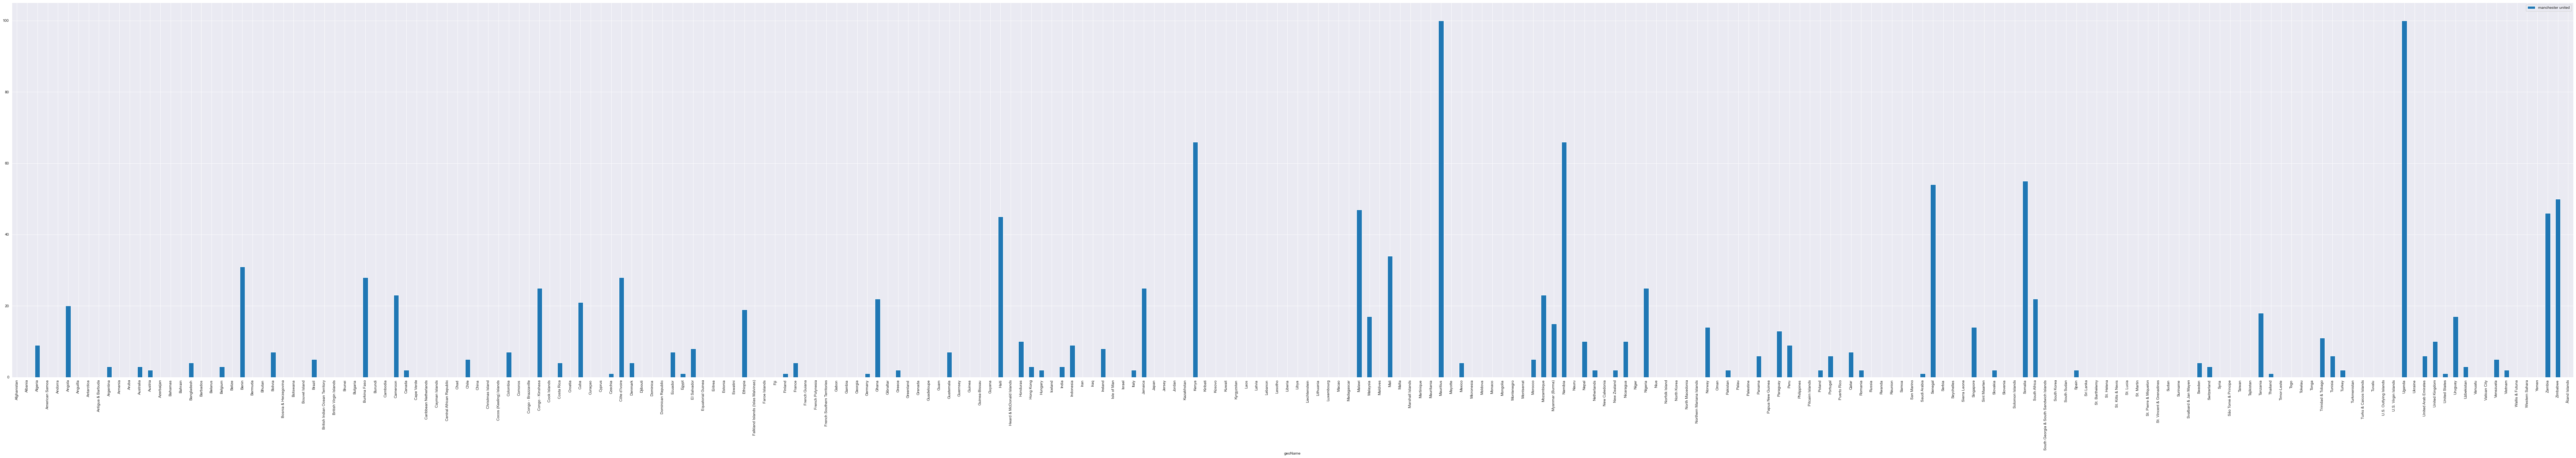

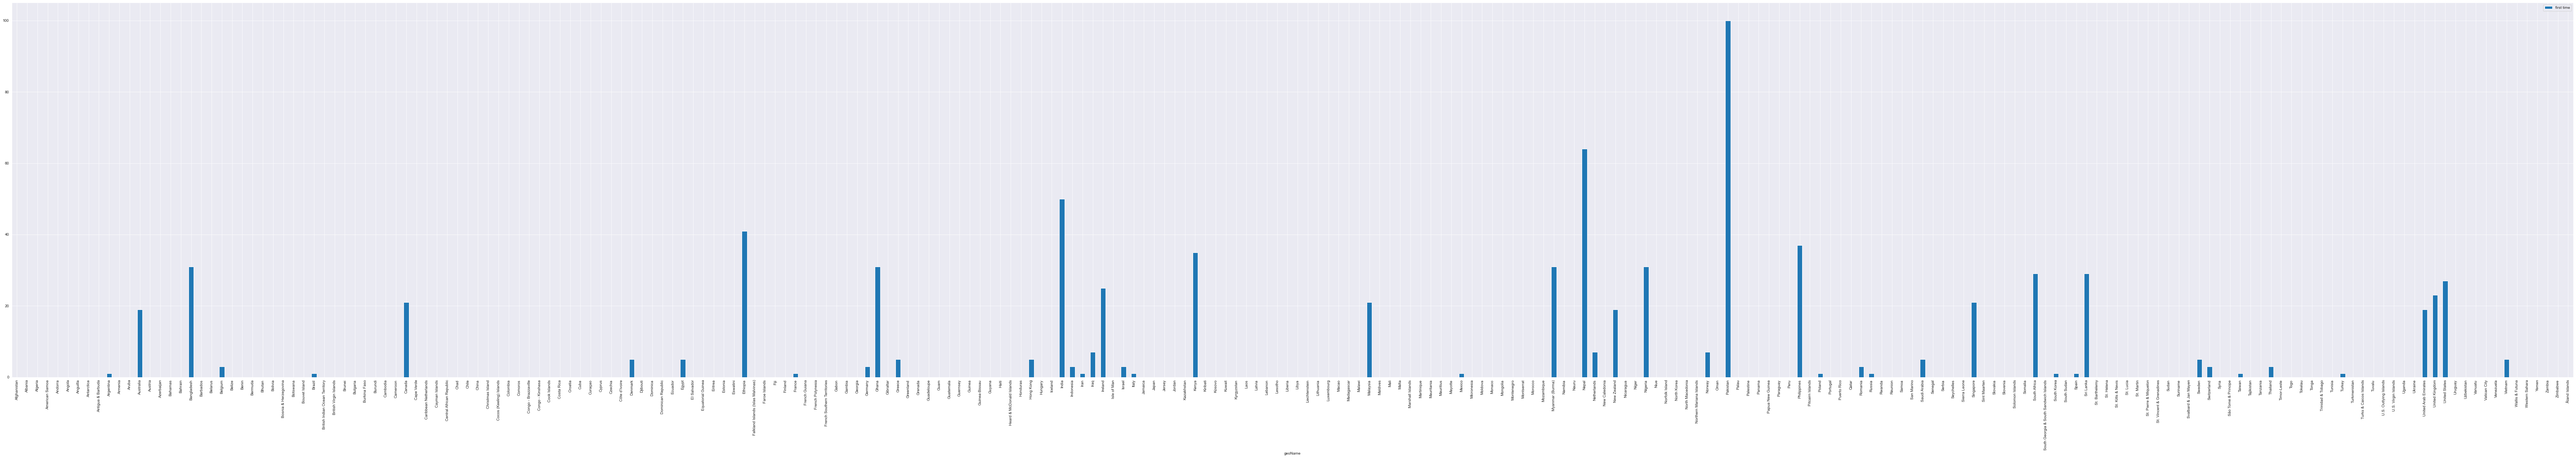

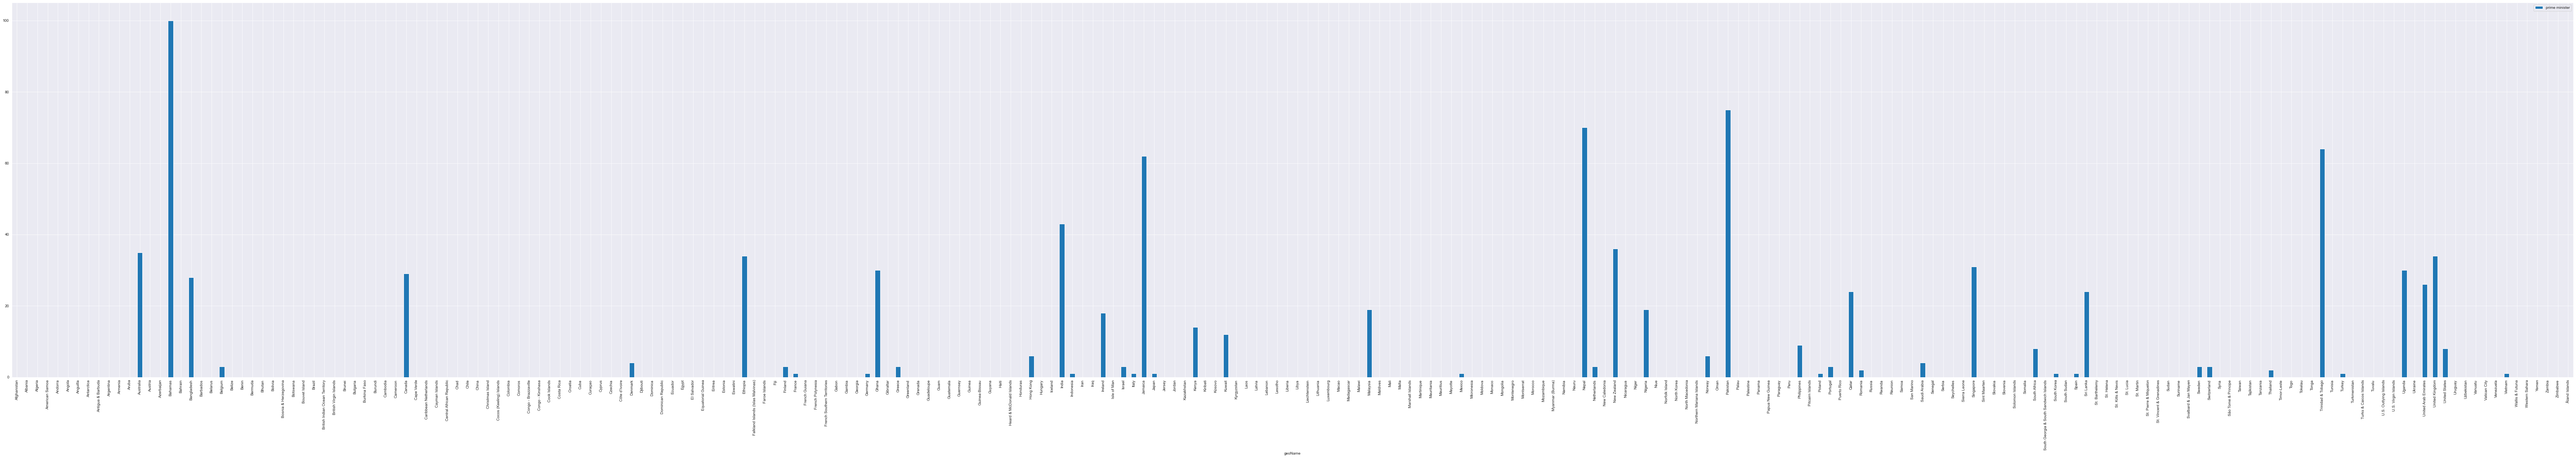

In [29]:
if TRENDS:
    for kw in top_kws:
        trend_data.reset_index().plot(x='geoName', y=kw, figsize=(120, 18), kind='bar')

## Top 25 countries to google the keywords

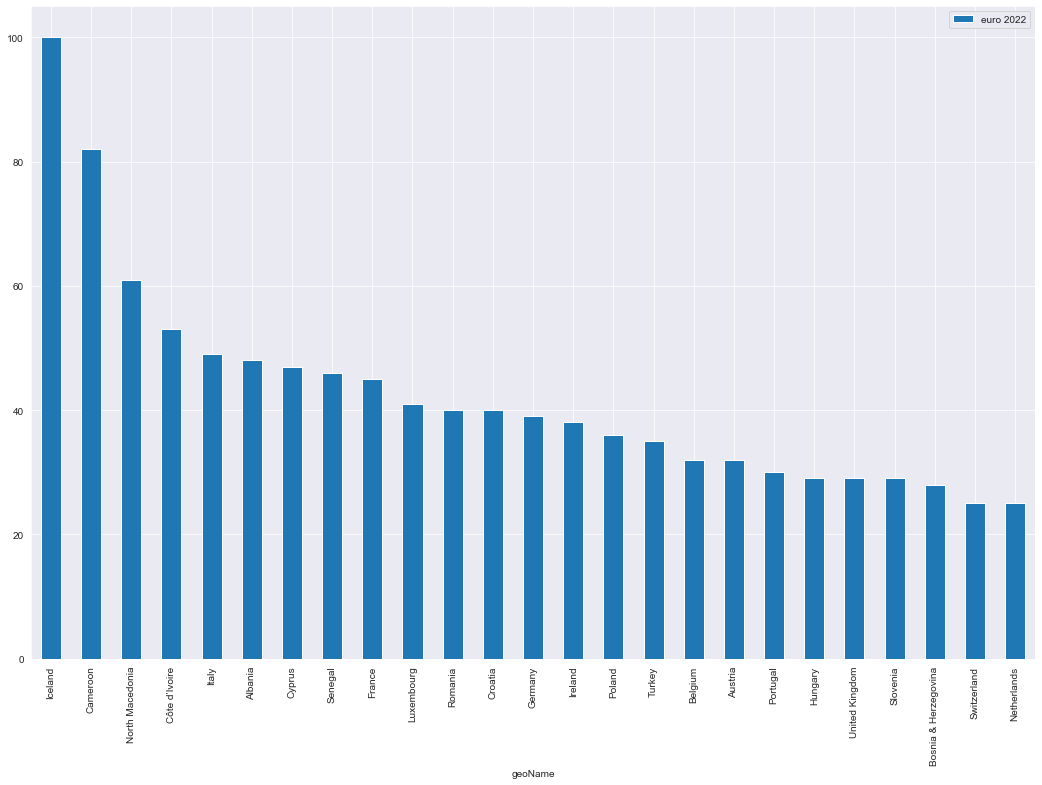

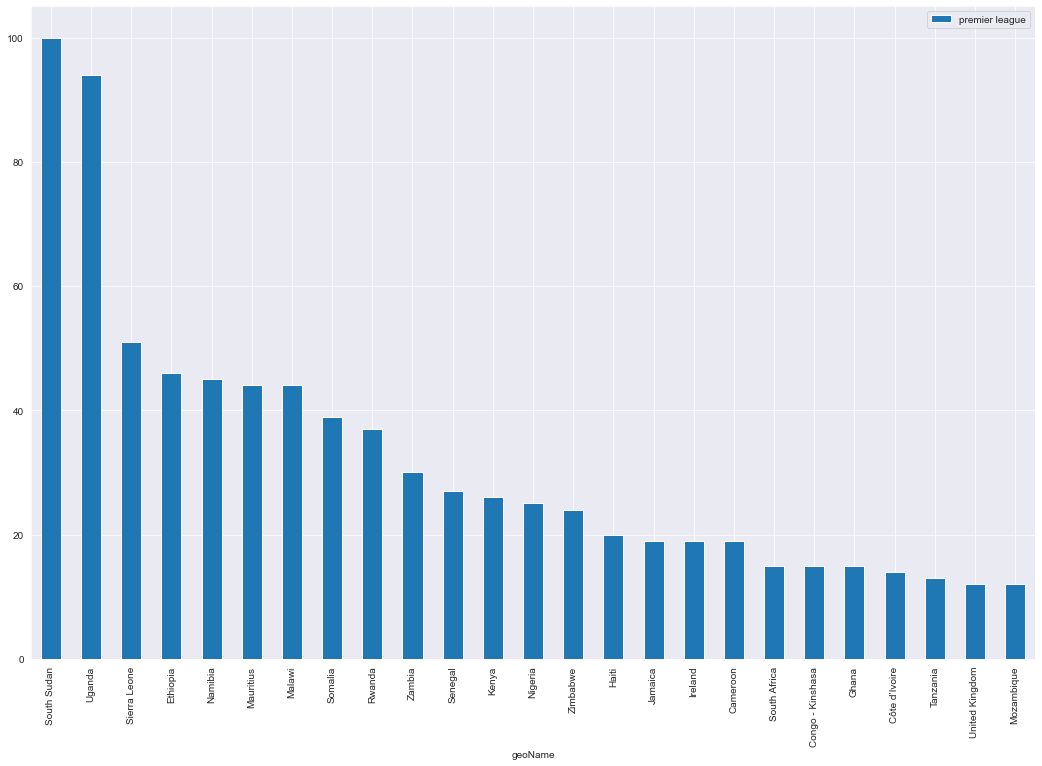

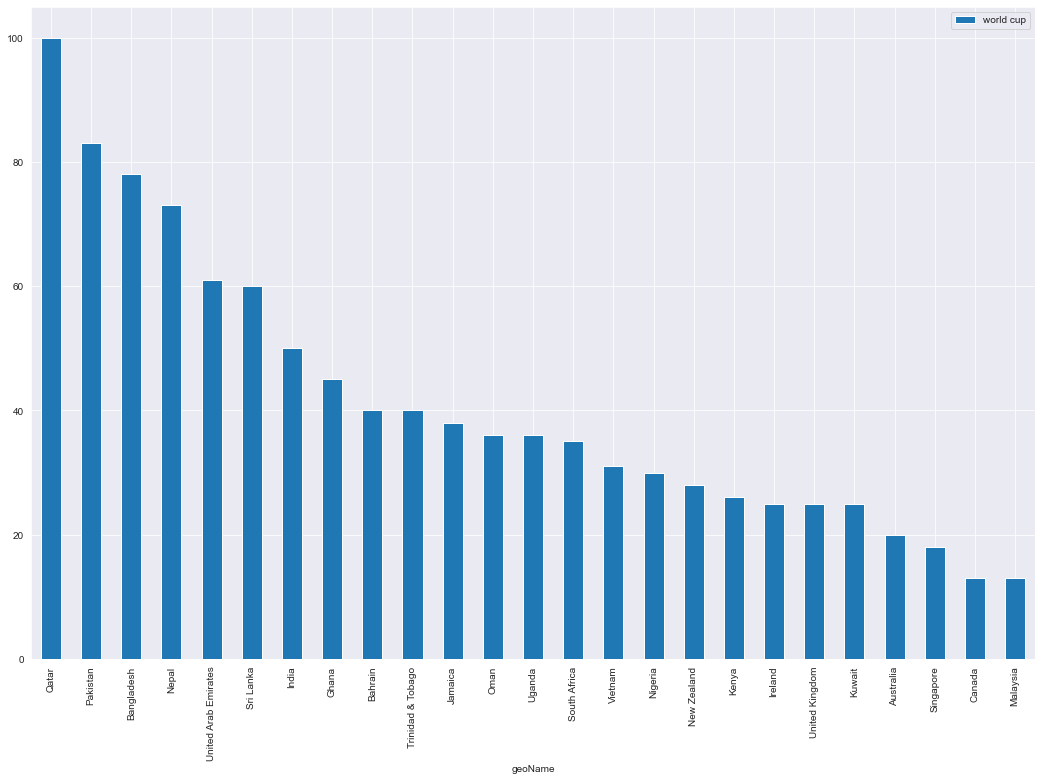

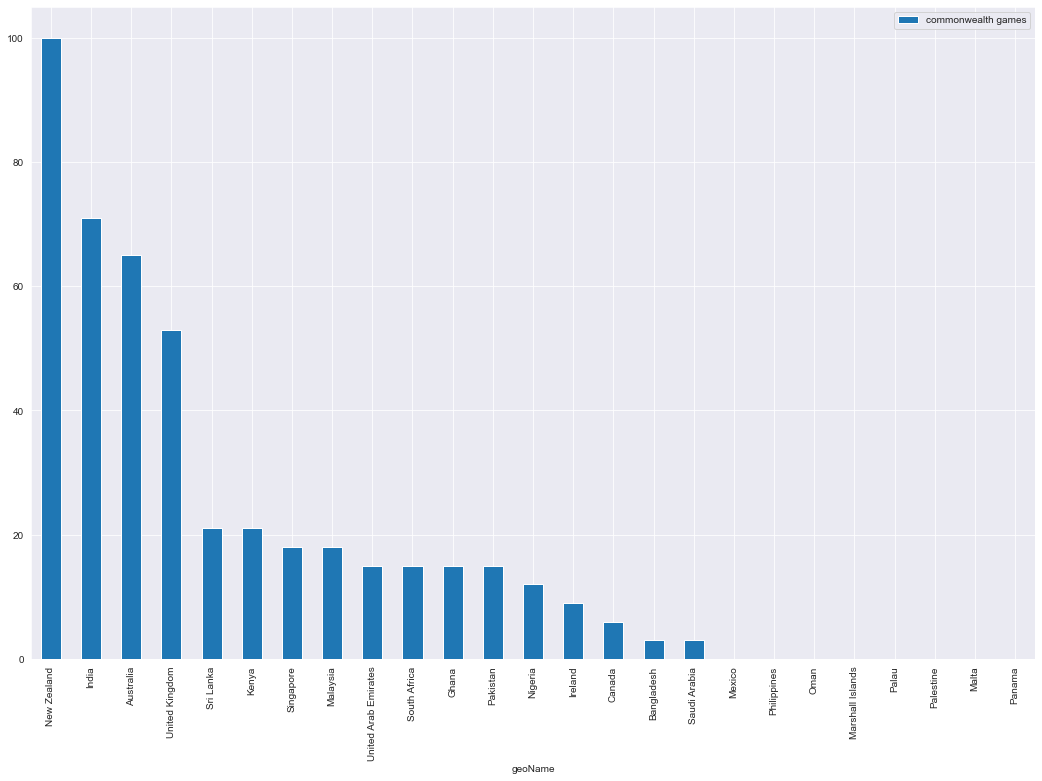

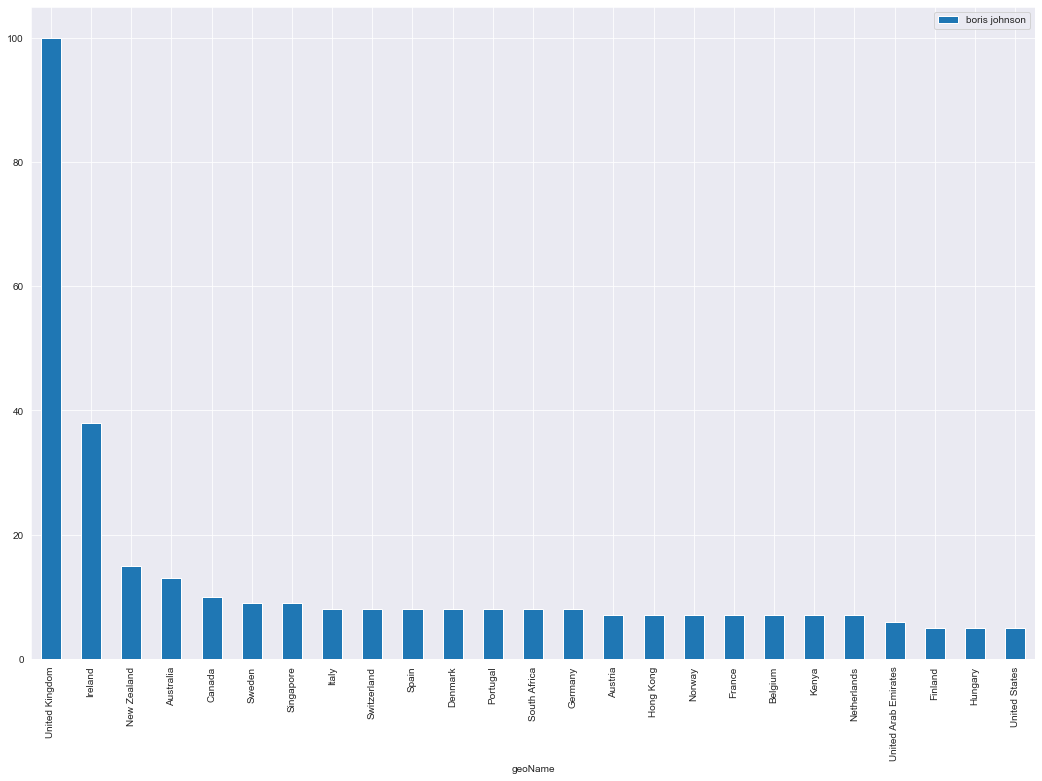

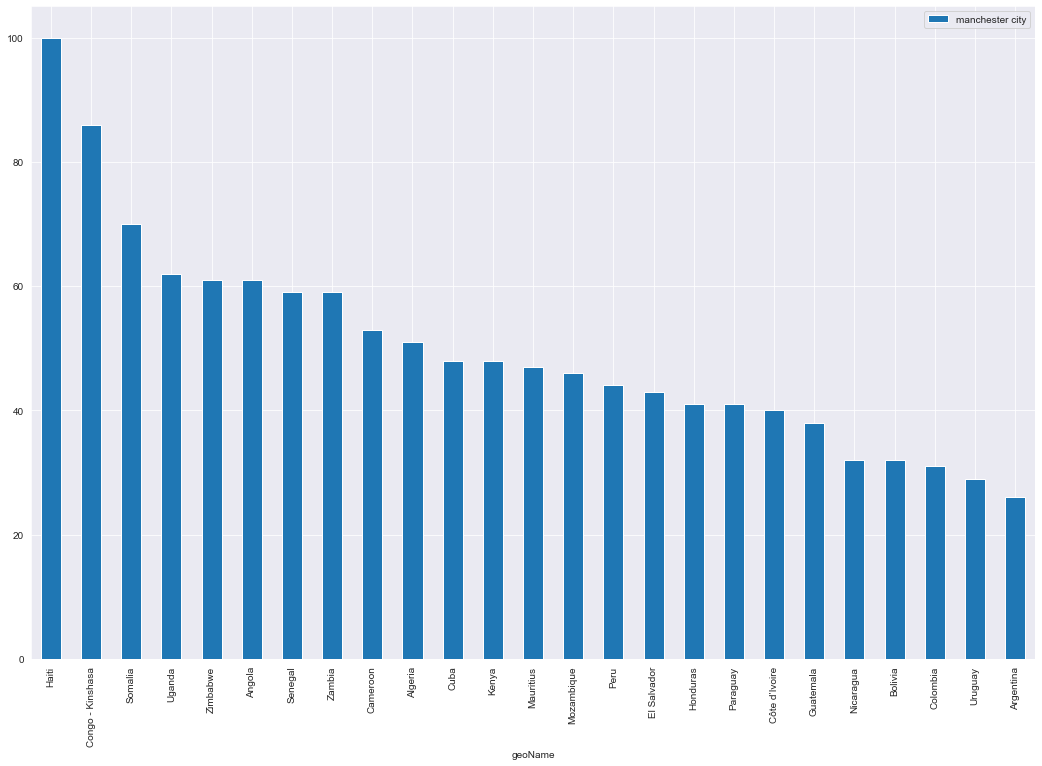

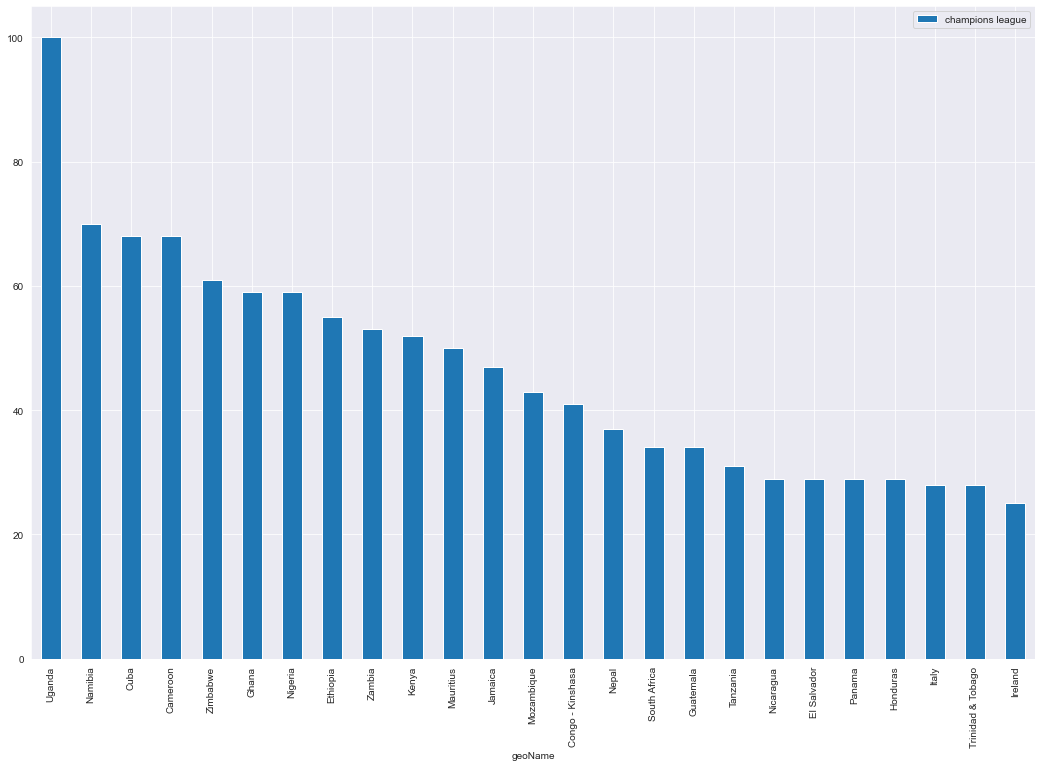

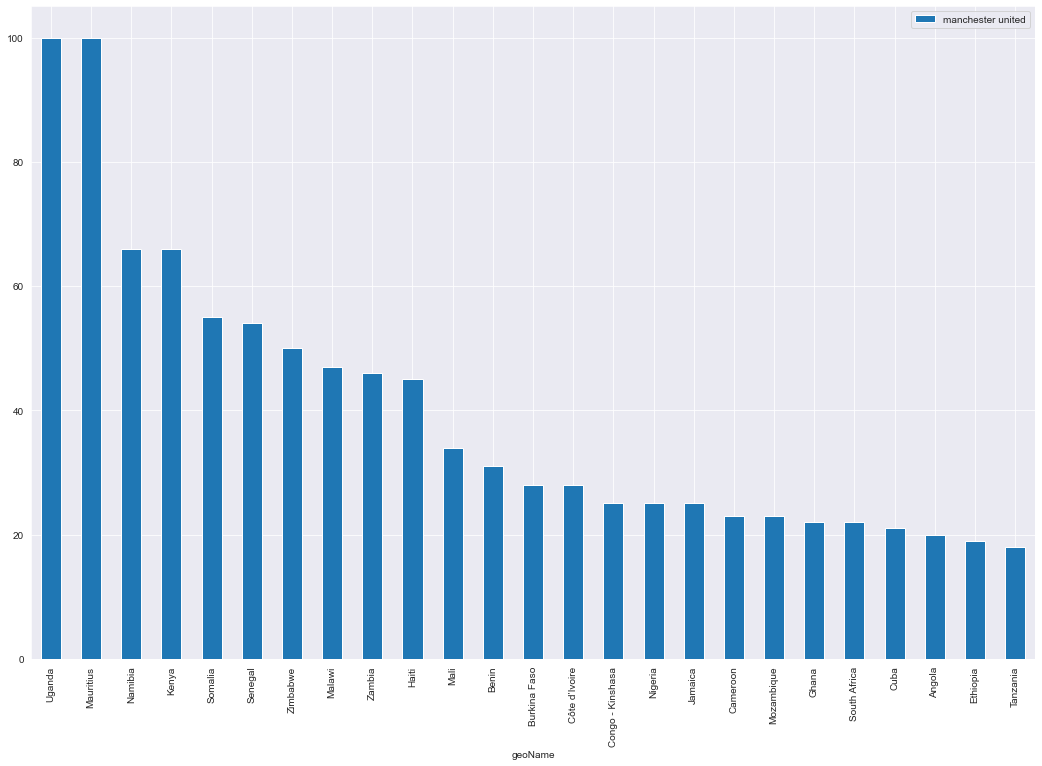

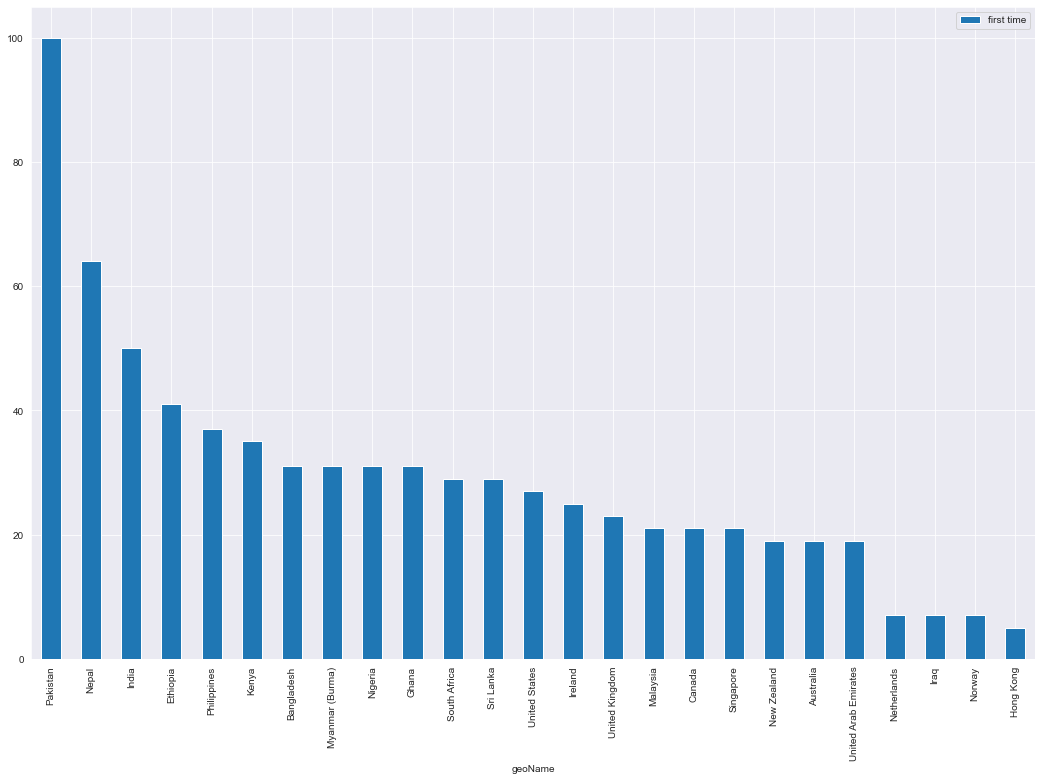

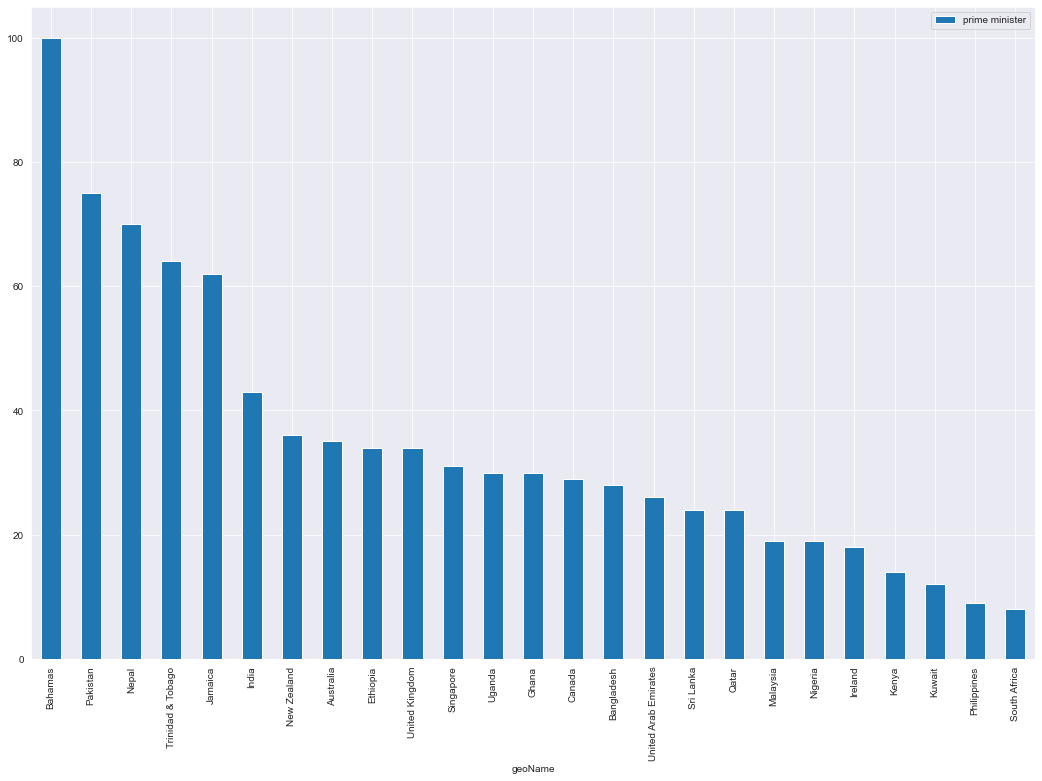

In [30]:
if TRENDS:
    for kw in top_kws:
        trend_data.sort_values(by=[kw], ascending=False)[:25].reset_index().plot(x='geoName', y=kw, figsize=(18, 12), kind='bar')

In [31]:
if TRENDS:
    for kw in top_kws:
        trend_tmp = trend_data.reset_index()
        trend_tmp = trend_tmp[trend_tmp[kw] > 0]

        fig = px.scatter_geo(trend_tmp, locations='geoName', color='geoName',
                             hover_name='geoName', size=kw,
                             projection='natural earth', locationmode='country names', title=kw)
        fig.show()

## Keywords (2-grams) suggestions

In [35]:
suggestions_data = pd.DataFrame()
suggest_terms = pd.Series(dtype=str)
if TRENDS:
    for kw_idx in bigram_freq_title['N-gram'].index[:5]:
        kw = ' '.join(bigram_freq_title.loc[kw_idx, 'N-gram'])
        suggests = pd.DataFrame(trends.suggestions(keyword=kw)).drop(columns=['mid'])
        
        suggest_terms = pd.concat([suggest_terms, pd.Series([kw] * len(suggests))])
        
        suggestions_data = pd.concat([suggestions_data, suggests])
        time.sleep(2)
suggestions_data = pd.concat([suggestions_data.reset_index(drop=True), suggest_terms.reset_index(drop=True)], axis=1)
suggestions_data

title  \
0                 UEFA Women's EURO England 2022   
1      2022 European Men's Handball Championship   
2              UEFA Women's Euro 2021 qualifying   
3                          UEFA Champions League   
4                                           Euro   
5                                 Premier League   
6                                         LaLiga   
7                                 Premier League   
8                         Russian Premier League   
9                        Egyptian Premier League   
10                       ICC Men's T20 World Cup   
11                  2021 ICC Men's T20 World Cup   
12  2022 FIFA World Cup qualification - CONMEBOL   
13                           FIFA Club World Cup   
14    2022 FIFA World Cup qualification CONCACAF   
15                            Commonwealth Games   
16            Birmingham 2022 Commonwealth Games   
17                       2018 Commonwealth Games   
18                       2010 Commonwealth Games   
19                 Commonwealth Games Federation   
20                                 Boris Johnson   
21                       Second Johnson ministry   
22          Just Boris: A Tale of Blond Ambition   

                                          type                   0  
0                                   Tournament           euro 2022  
1                                   Tournament           euro 2022  
2                                   Tournament           euro 2022  
3                         Football competition           euro 2022  
4                                     Currency           euro 2022  
5                              Football league      premier league  
6                              Football league      premier league  
7                                        Topic      premier league  
8                              Football league      premier league  
9                              Football league      premier league  
10                                Championship           world cup  
11                                  Tournament           world cup  
12                                  Tournament           world cup  
13                        Football competition           world cup  
14                                  Tournament           world cup  
15                                       Topic  commonwealth games  
16                           Multi-sport event  commonwealth games  
17                           Multi-sport event  commonwealth games  
18                           Multi-sport event  commonwealth games  
19                                       Topic  commonwealth games  
20  Member of Parliament of the United Kingdom       boris johnson  
21                                       Topic       boris johnson  
22                                       Topic       boris johnson

In [36]:
suggestions_data

title  \
0                 UEFA Women's EURO England 2022   
1      2022 European Men's Handball Championship   
2              UEFA Women's Euro 2021 qualifying   
3                          UEFA Champions League   
4                                           Euro   
5                                 Premier League   
6                                         LaLiga   
7                                 Premier League   
8                         Russian Premier League   
9                        Egyptian Premier League   
10                       ICC Men's T20 World Cup   
11                  2021 ICC Men's T20 World Cup   
12  2022 FIFA World Cup qualification - CONMEBOL   
13                           FIFA Club World Cup   
14    2022 FIFA World Cup qualification CONCACAF   
15                            Commonwealth Games   
16            Birmingham 2022 Commonwealth Games   
17                       2018 Commonwealth Games   
18                       2010 Commonwealth Games   
19                 Commonwealth Games Federation   
20                                 Boris Johnson   
21                       Second Johnson ministry   
22          Just Boris: A Tale of Blond Ambition   

                                          type                   0  
0                                   Tournament           euro 2022  
1                                   Tournament           euro 2022  
2                                   Tournament           euro 2022  
3                         Football competition           euro 2022  
4                                     Currency           euro 2022  
5                              Football league      premier league  
6                              Football league      premier league  
7                                        Topic      premier league  
8                              Football league      premier league  
9                              Football league      premier league  
10                                Championship           world cup  
11                                  Tournament           world cup  
12                                  Tournament           world cup  
13                        Football competition           world cup  
14                                  Tournament           world cup  
15                                       Topic  commonwealth games  
16                           Multi-sport event  commonwealth games  
17                           Multi-sport event  commonwealth games  
18                           Multi-sport event  commonwealth games  
19                                       Topic  commonwealth games  
20  Member of Parliament of the United Kingdom       boris johnson  
21                                       Topic       boris johnson  
22                                       Topic       boris johnson

## Related queries

In [158]:
if TRENDS: # rerun only on demand, since very long running code
    related_data = pd.DataFrame()
    for kw_idx in bigram_freq_title['N-gram'].index[:5]:
        kw = ' '.join(bigram_freq_title.loc[kw_idx, 'N-gram'])
        
        trends.build_payload(kw_list=[kw], timeframe=timeframe)
        related_queries = trends.related_queries()[kw]['top']
        related_data = pd.concat([related_data, pd.concat([related_queries, pd.Series([kw] * len(related_queries))], axis=1)])
        
        time.sleep(2)
related_data

query  value              0
0               euro 2021    100      euro 2022
1           euro cup 2022     93      euro 2022
2                euro cup     92      euro 2022
3          2022 world cup     76      euro 2022
4               world cup     75      euro 2022
..                    ...    ...            ...
20  boris johnson twitter     20  boris johnson
21   boris johnson update     18  boris johnson
22      boris johnson age     18  boris johnson
23     boris johnson wife     18  boris johnson
24   boris johnson corona     17  boris johnson

[125 rows x 3 columns]

# Cleaning data (removing punctuation)

In [159]:
# lower and remove punctuation
data['description_cleaned'] = data['description'].str.lower().apply(lambda x: re.sub(f'[{re.escape(string.punctuation)}]', '', x))
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  \
0     The Ukrainian president says the country will ...   
1     Jeremy Bowen was on the frontline in Irpin, as...   
2     One of the world's biggest fertiliser firms sa...   
3     The parents of the Manchester Arena bombing's ...   
4     Consumers are feeling the impact of higher ene...   
...                                                 ...   
7359  Saracens battle back from 17-0 down to beat Ha...   
7360  Thousands of people have lined up for miles to...   
7361  Sitting with the heads of state at Monday's fu...   
7362  When the monarch visited a US housing project ...   
7363  The Queen's association with Windsor Great Par...   

                                    description_cleaned  description_polarity  \
0     the ukrainian president says the country will ...              0.000000   
1     jeremy bowen was on the frontline in irpin as ...              0.000000   
2     one of the worlds biggest fertiliser firms say...             -0.200000   
3     the parents of the manchester arena bombings y...             -0.075000   
4     consumers are feeling the impact of higher ene...              0.250000   
...                                                 ...                   ...   
7359  saracens battle back from 170 down to beat har...              0.125000   
7360  thousands of people have lined up for miles to...              0.000000   
7361  sitting with the heads of state at mondays fun...              0.00000

In [160]:
# remove redundant spaces
data['description_cleaned'] = data['description_cleaned'].str.strip()
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  \
0     The Ukrainian president says the country will ...   
1     Jeremy Bowen was on the frontline in Irpin, as...   
2     One of the world's biggest fertiliser firms sa...   
3     The parents of the Manchester Arena bombing's ...   
4     Consumers are feeling the impact of higher ene...   
...                                                 ...   
7359  Saracens battle back from 17-0 down to beat Ha...   
7360  Thousands of people have lined up for miles to...   
7361  Sitting with the heads of state at Monday's fu...   
7362  When the monarch visited a US housing project ...   
7363  The Queen's association with Windsor Great Par...   

                                    description_cleaned  description_polarity  \
0     the ukrainian president says the country will ...              0.000000   
1     jeremy bowen was on the frontline in irpin as ...              0.000000   
2     one of the worlds biggest fertiliser firms say...             -0.200000   
3     the parents of the manchester arena bombings y...             -0.075000   
4     consumers are feeling the impact of higher ene...              0.250000   
...                                                 ...                   ...   
7359  saracens battle back from 170 down to beat har...              0.125000   
7360  thousands of people have lined up for miles to...              0.000000   
7361  sitting with the heads of state at mondays fun...              0.00000

In [42]:
data['description_cleaned'][0], data['description_cleaned'][1]

('the ukrainian president says the country will not forgive or forget those who murder its civilians',
 'jeremy bowen was on the frontline in irpin as residents came under russian fire while trying to flee')

In [43]:
data['description_cleaned'].apply(len).describe()

count    7364.000000
mean      102.960619
std        21.651765
min        34.000000
25%        92.000000
50%        97.000000
75%       106.000000
max       250.000000
Name: description_cleaned, dtype: float64

# Lemmatization

In [44]:
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('civilians')

'civilian'

In [45]:
data['description_cleaned']=data['description_cleaned'].apply(lambda x: ' '.join(map(lemmatizer.lemmatize, filter(lambda w: w not in STOPWORDS, nltk.tokenize.word_tokenize(x)))))
data['description'][100], data['description_cleaned'][100]

('The war in Ukraine will lead to an even tighter squeeze on living standards this spring, a think tank says.',
 'war ukraine lead even tighter squeeze living standard spring think tank say')

## Normalizing data

In [161]:
cv = CountVectorizer(analyzer='word')
cv_data = cv.fit_transform(data['description_cleaned'])
dtm_data = pd.DataFrame(cv_data.toarray(), columns=cv.get_feature_names_out())
dtm_data.index = data.index
dtm_data.head(5)

00  007  008  01  0100  03mm  05  075  09  0900  ...  zoom  zoos  zsl  \
0   0    0    0   0     0     0   0    0   0     0  ...     0     0    0   
1   0    0    0   0     0     0   0    0   0     0  ...     0     0    0   
2   0    0    0   0     0     0   0    0   0     0  ...     0     0    0   
3   0    0    0   0     0     0   0    0   0     0  ...     0     0    0   
4   0    0    0   0     0     0   0    0   0     0  ...     0     0    0   

   zuckerberg  zulu  zurich  zuu  zverev  zwelithini  úsuga  
0           0     0       0    0       0           0      0  
1           0     0       0    0       0           0      0  
2           0     0       0    0       0           0      0  
3           0     0       0    0       0           0      0  
4           0     0       0    0       0           0      0  

[5 rows x 15279 columns]

# Wordclouds

In [47]:
# Function for generating word clouds
def generate_wordcloud(data, title, bg='black', colormap='Dark2', mask=None):
    wc = WordCloud(width=1600, height=1080, max_words=150, colormap=colormap, mask=mask, background_color=bg).generate_from_frequencies(data)
    plt.figure(figsize=(16,12))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('\n'.join(wrap(title,60)),fontsize=26)
    plt.show()

In [48]:
ASSETS_PATH = './assets'

In [49]:
f100_mask = np.array(Image.open(ASSETS_PATH + '/100.png'))

In [50]:
latest100indexes = data.sort_values(by=['pubDate'], ascending=False).index

## Latest 100 titles

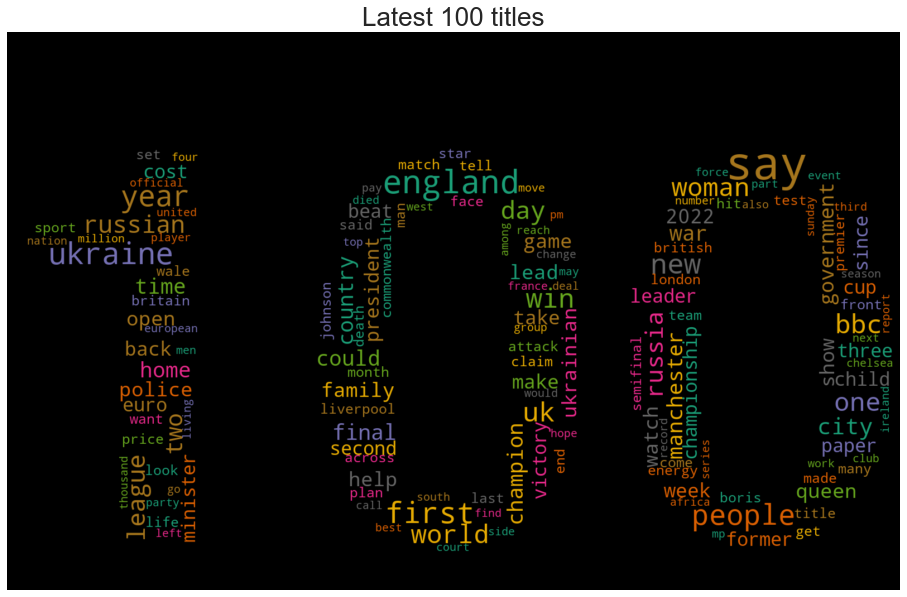

In [51]:
generate_wordcloud(dtm_data.loc[latest100indexes].T.sum(axis=1), 'Latest 100 titles', mask=f100_mask)

## Latest 500 titles

In [52]:
f500_mask = np.array(Image.open(ASSETS_PATH + '/500.png'))

In [53]:
latest500indexes = data.sort_values(by=['pubDate'], ascending=False).index

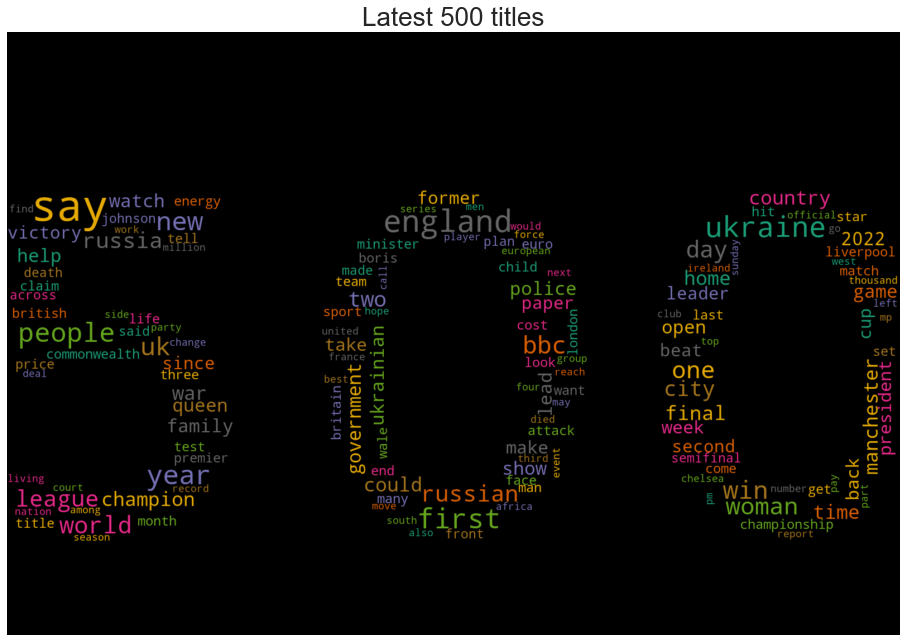

In [54]:
generate_wordcloud(dtm_data.loc[latest500indexes].T.sum(axis=1), 'Latest 500 titles', mask=f500_mask)

In [55]:
data['description_polarity']=data['description_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  \
0     The Ukrainian president says the country will ...   
1     Jeremy Bowen was on the frontline in Irpin, as...   
2     One of the world's biggest fertiliser firms sa...   
3     The parents of the Manchester Arena bombing's ...   
4     Consumers are feeling the impact of higher ene...   
...                                                 ...   
7359  Saracens battle back from 17-0 down to beat Ha...   
7360  Thousands of people have lined up for miles to...   
7361  Sitting with the heads of state at Monday's fu...   
7362  When the monarch visited a US housing project ...   
7363  The Queen's association with Windsor Great Par...   

                                    description_cleaned  description_polarity  
0     ukrainian president say country forgive forget...              0.000000  
1     jeremy bowen frontline irpin resident came rus...              0.000000  
2     one world biggest fertiliser firm say conflict...             -0.200000  
3     parent manchester arena bombing youngest victi...             -0.075000  
4     consumer feeling impact higher energy cost fue...              0.250000  
...                                                 ...                   ...  
7359  saracen battle back 170 beat harlequin thrilli...              0.125000  
7360  thousand people lined mile pay respect queen l...              0.000000  
7361  sitting head state monday funeral monty robert...              0.000000  
7362 

In [56]:
data.describe()

description_polarity
count           7364.000000
mean               0.052595
std                0.232978
min               -1.000000
25%                0.000000
50%                0.000000
75%                0.136364
max                1.000000

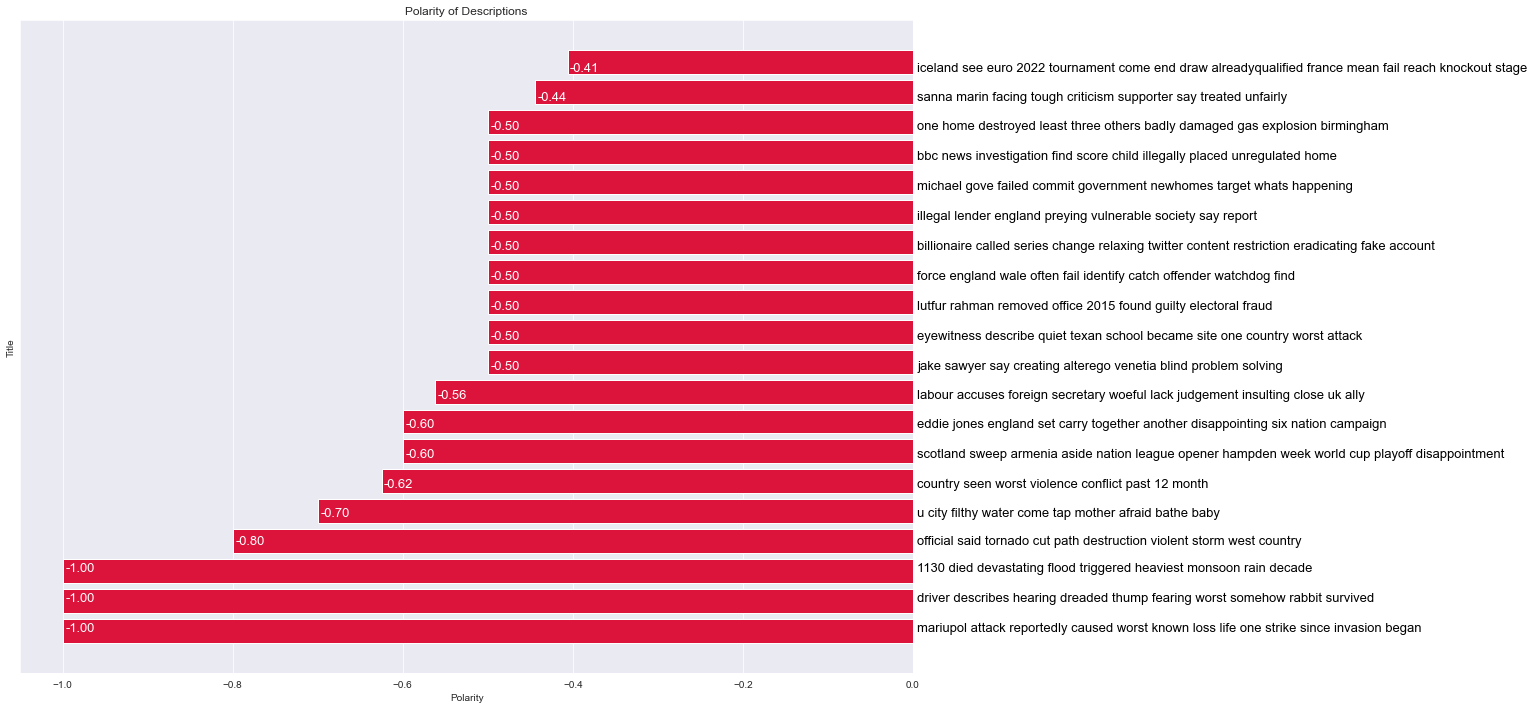

In [57]:
title_polarity_sorted = data['description_polarity'].sort_values(ascending=True).copy()[:200:10]

plt.figure(figsize=(16,12))
plt.xlabel('Polarity')
plt.ylabel('Title')
plt.title('Polarity of Descriptions')
polarity_graph=plt.barh(np.arange(len(title_polarity_sorted.index)), title_polarity_sorted, color='crimson')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(0.005, bar.get_y() - bar.get_width() / 2, str(data['description_cleaned'][polarity_idx]), va='center', fontsize=13, color='black')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(bar.get_width() + 0.003, bar.get_y() - bar.get_width() / 2,'{:.2f}'.format(title_polarity_sorted[polarity_idx]), va='center', fontsize=13, color='white')

plt.yticks([])
plt.show()

In [58]:
title_polarity_sorted

773    -1.000000
4043   -1.000000
6660   -1.000000
2933   -0.800000
6824   -0.700000
391    -0.625000
3623   -0.600000
650    -0.600000
6541   -0.562500
1447   -0.500000
3095   -0.500000
2370   -0.500000
5980   -0.500000
1962   -0.500000
643    -0.500000
2573   -0.500000
5132   -0.500000
4261   -0.500000
6588   -0.444444
5127   -0.406250
Name: description_polarity, dtype: float64

In [59]:
thumb_down_mask = np.array(Image.open(ASSETS_PATH + '/thumb-up.png').transpose(method=Image.FLIP_TOP_BOTTOM))
thumb_down_mask-=1
thumb_down_mask[thumb_down_mask == 0] = 255

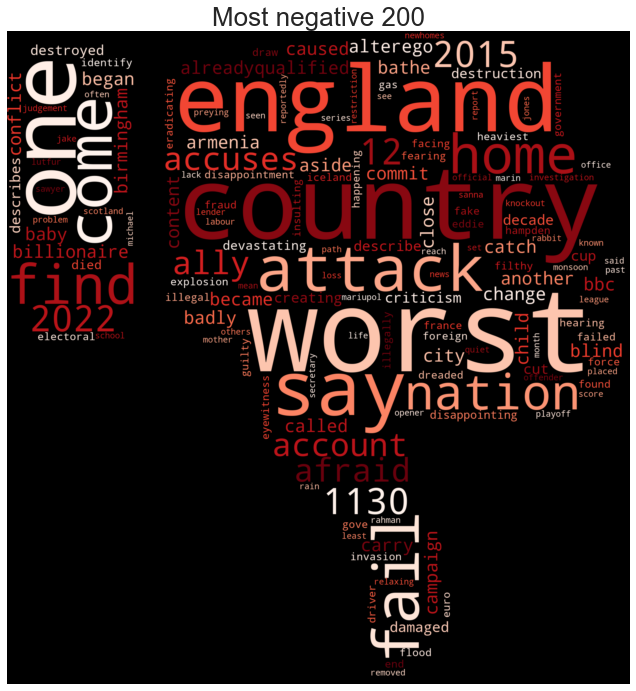

In [60]:
generate_wordcloud(dtm_data.loc[title_polarity_sorted.index].T.sum(axis=1), 'Most negative 200', colormap='Reds', mask=thumb_down_mask)

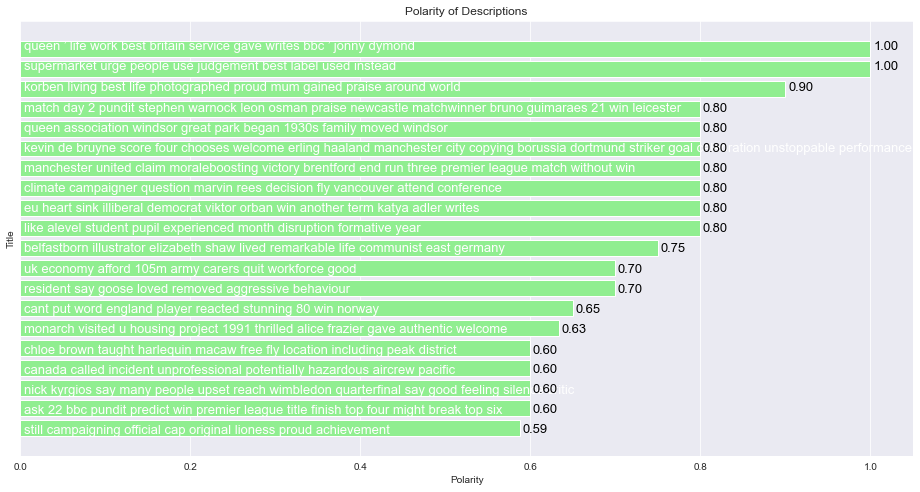

In [61]:
title_polarity_sorted = data['description_polarity'].sort_values(ascending=True).copy()[-200::10]

plt.figure(figsize=(16,8))
plt.xlabel('Polarity')
plt.ylabel('Title')
plt.title('Polarity of Descriptions')
polarity_graph=plt.barh(np.arange(len(title_polarity_sorted.index)), title_polarity_sorted, color='lightgreen')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(0.005, bar.get_y() + bar.get_width() / 2, str(data['description_cleaned'][polarity_idx]), va='center', fontsize=13, color='white')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(bar.get_width() + 0.003, bar.get_y() + bar.get_width() / 2,'{:.2f}'.format(title_polarity_sorted[polarity_idx]), va='center', fontsize=13, color='black')
    
plt.yticks([])
plt.show()

In [62]:
thumb_up_mask = np.array(Image.open(ASSETS_PATH + '/thumb-up.png'))
thumb_up_mask-=1
thumb_up_mask[thumb_up_mask == 0] = 255

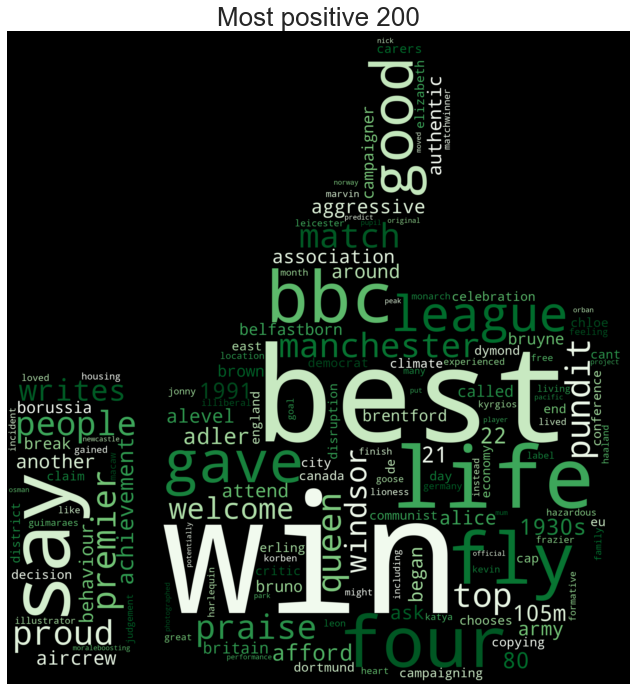

In [63]:
generate_wordcloud(dtm_data.loc[title_polarity_sorted.index].T.sum(axis=1), 'Most positive 200', colormap='Greens', mask=thumb_up_mask)